## 🧠 Model Training

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
trainwdrop_log = pd.read_csv('../dataset/cleanedwdrop_log_encode_sales_data.csv')
trainwfill_log = pd.read_csv('../dataset/cleanedwfill_log_encode_sales_data.csv')
trainwdrop_iso = pd.read_csv('../dataset/cleanedwdrop_iso_encode_sales_data.csv')
trainwfill_iso = pd.read_csv('../dataset/cleanedwfill_iso_encode_sales_data.csv')

In [3]:
trainwdrop_log.drop(columns=['year'], inplace=True)
trainwdrop_iso.drop(columns=['year'], inplace=True)

trainwfill_log.drop(columns=['year', 'manufacturer', 'model'], inplace=True)
trainwfill_iso.drop(columns=['year', 'manufacturer', 'model'], inplace=True)

In [4]:
#odometer can car_age into int
trainwdrop_log['car_age'] = trainwdrop_log['car_age'].astype(int)
trainwdrop_iso['car_age'] = trainwdrop_iso['car_age'].astype(int)
trainwfill_log['car_age'] = trainwfill_log['car_age'].astype(int)
trainwfill_iso['car_age'] = trainwfill_iso['car_age'].astype(int)

trainwdrop_log['odometer'] = trainwdrop_log['odometer'].astype(int)
trainwdrop_iso['odometer'] = trainwdrop_iso['odometer'].astype(int)
trainwfill_log['odometer'] = trainwfill_log['odometer'].astype(int)
trainwfill_iso['odometer'] = trainwfill_iso['odometer'].astype(int)

In [5]:
models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=42, verbosity=0)
}

In [6]:
datasets = {
    "Drop Log": trainwdrop_log.copy(),
    "Drop Iso": trainwdrop_iso.copy(),
    "Fill Log": trainwfill_log.copy(),
    "Fill Iso": trainwfill_iso.copy()
}

In [7]:
def evaluate(y, y_pred):
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    pmae = (mae / y.mean()) * 100
    return r2, rmse, mae, pmae

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_no_hyper_tune = []

# --- LOOP THROUGH DATASETS & MODELS ---
for name, df in datasets.items():
    X = df.drop(columns=["price"])
    y = df["price"]

    for model_name, model in models.items():
        y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

        r2, rmse, mae, pmae = evaluate(y, y_pred)

        results_no_hyper_tune.append({
            "Dataset": name,
            "Model": model_name,
            "R²": round(r2, 4),
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "PMAE (%)": round(pmae, 2)
        })

In [9]:
import pandas as pd

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_no_hyper_tune)

# Improved styled DataFrame for better header and width display
styled_results = results_df.style.format({
    "R²": "{:.4f}",
    "RMSE": "{:,.2f}",
    "MAE": "{:,.2f}",
    "PMAE (%)": "{:.2f}"
}).background_gradient(subset=["R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE", "MAE", "PMAE (%)"], cmap="Oranges") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_results


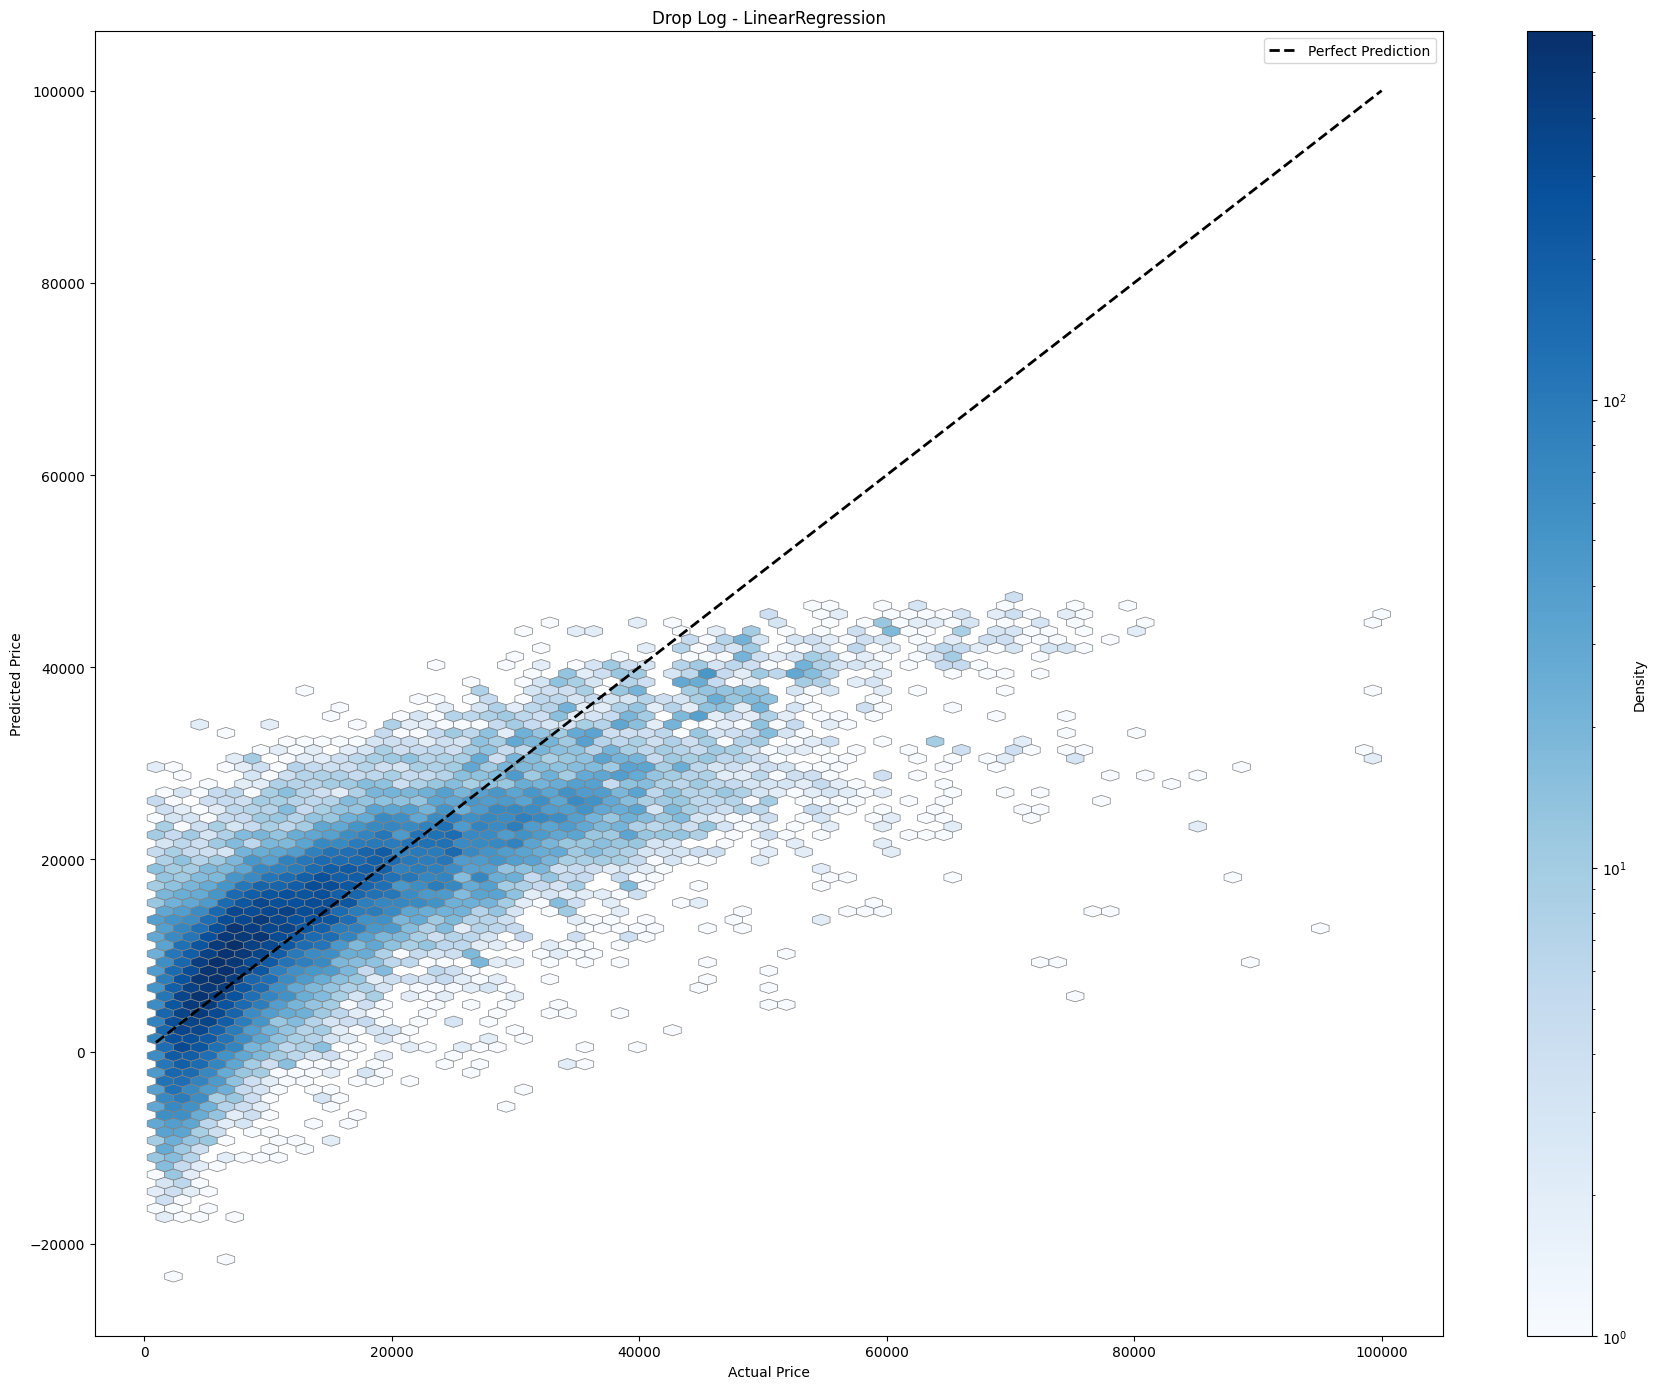

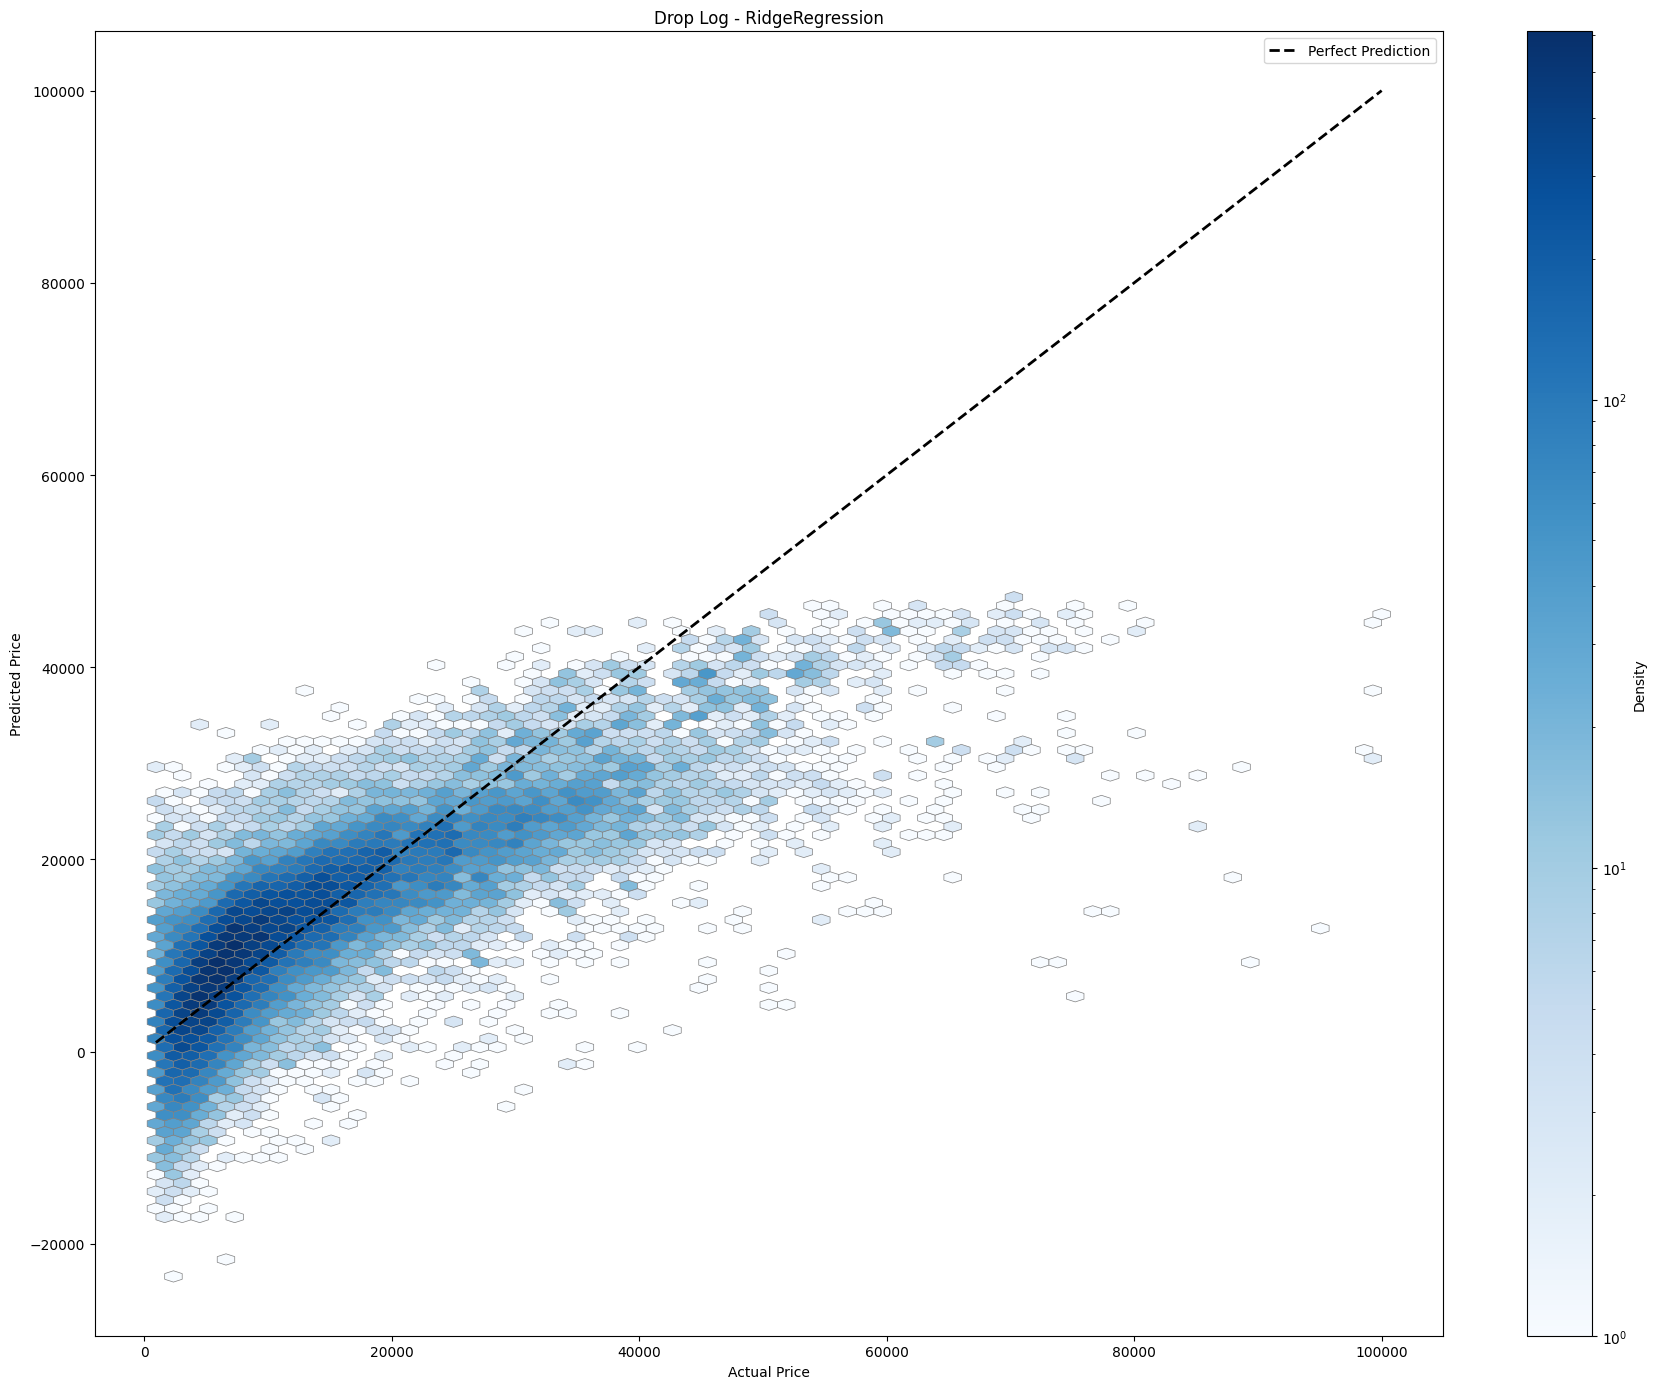

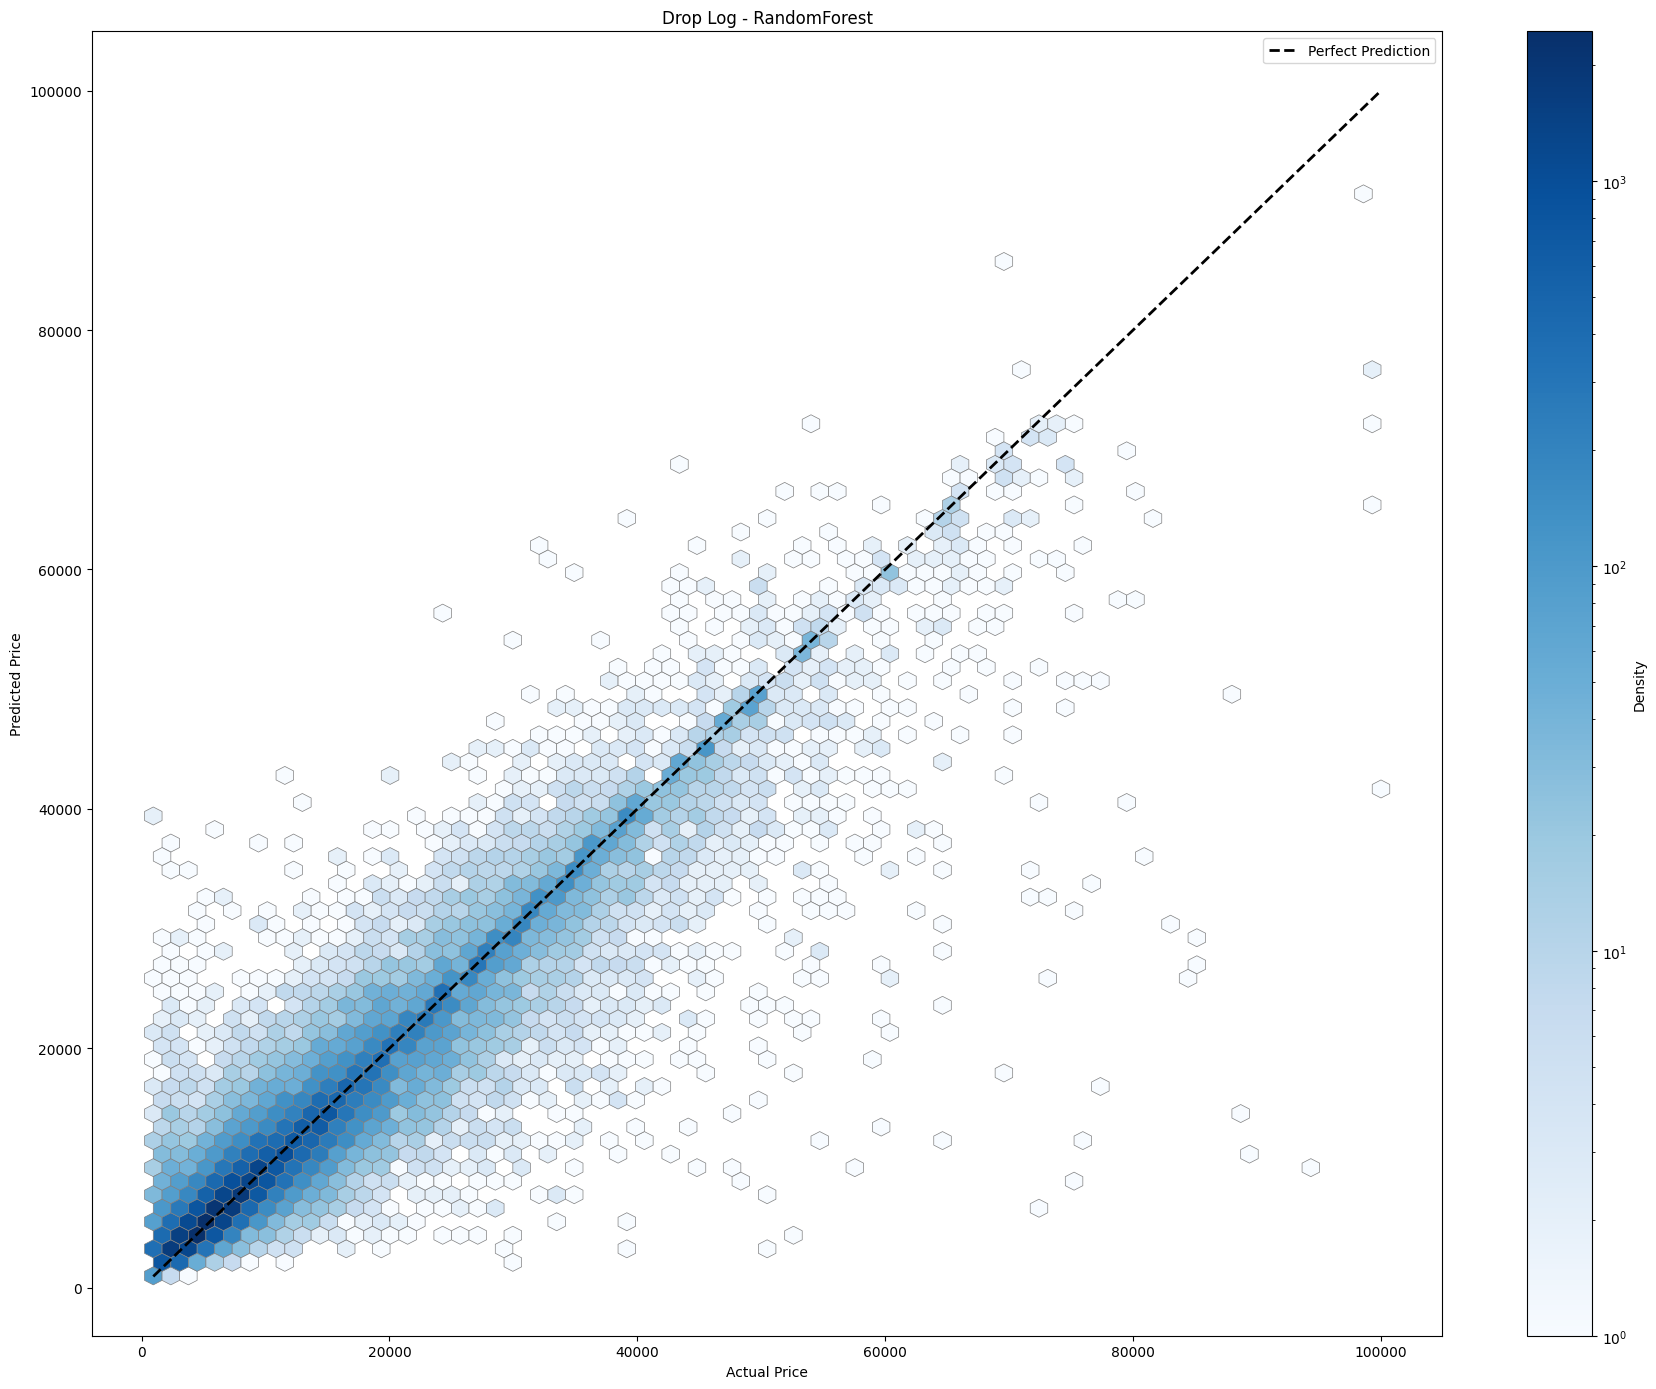

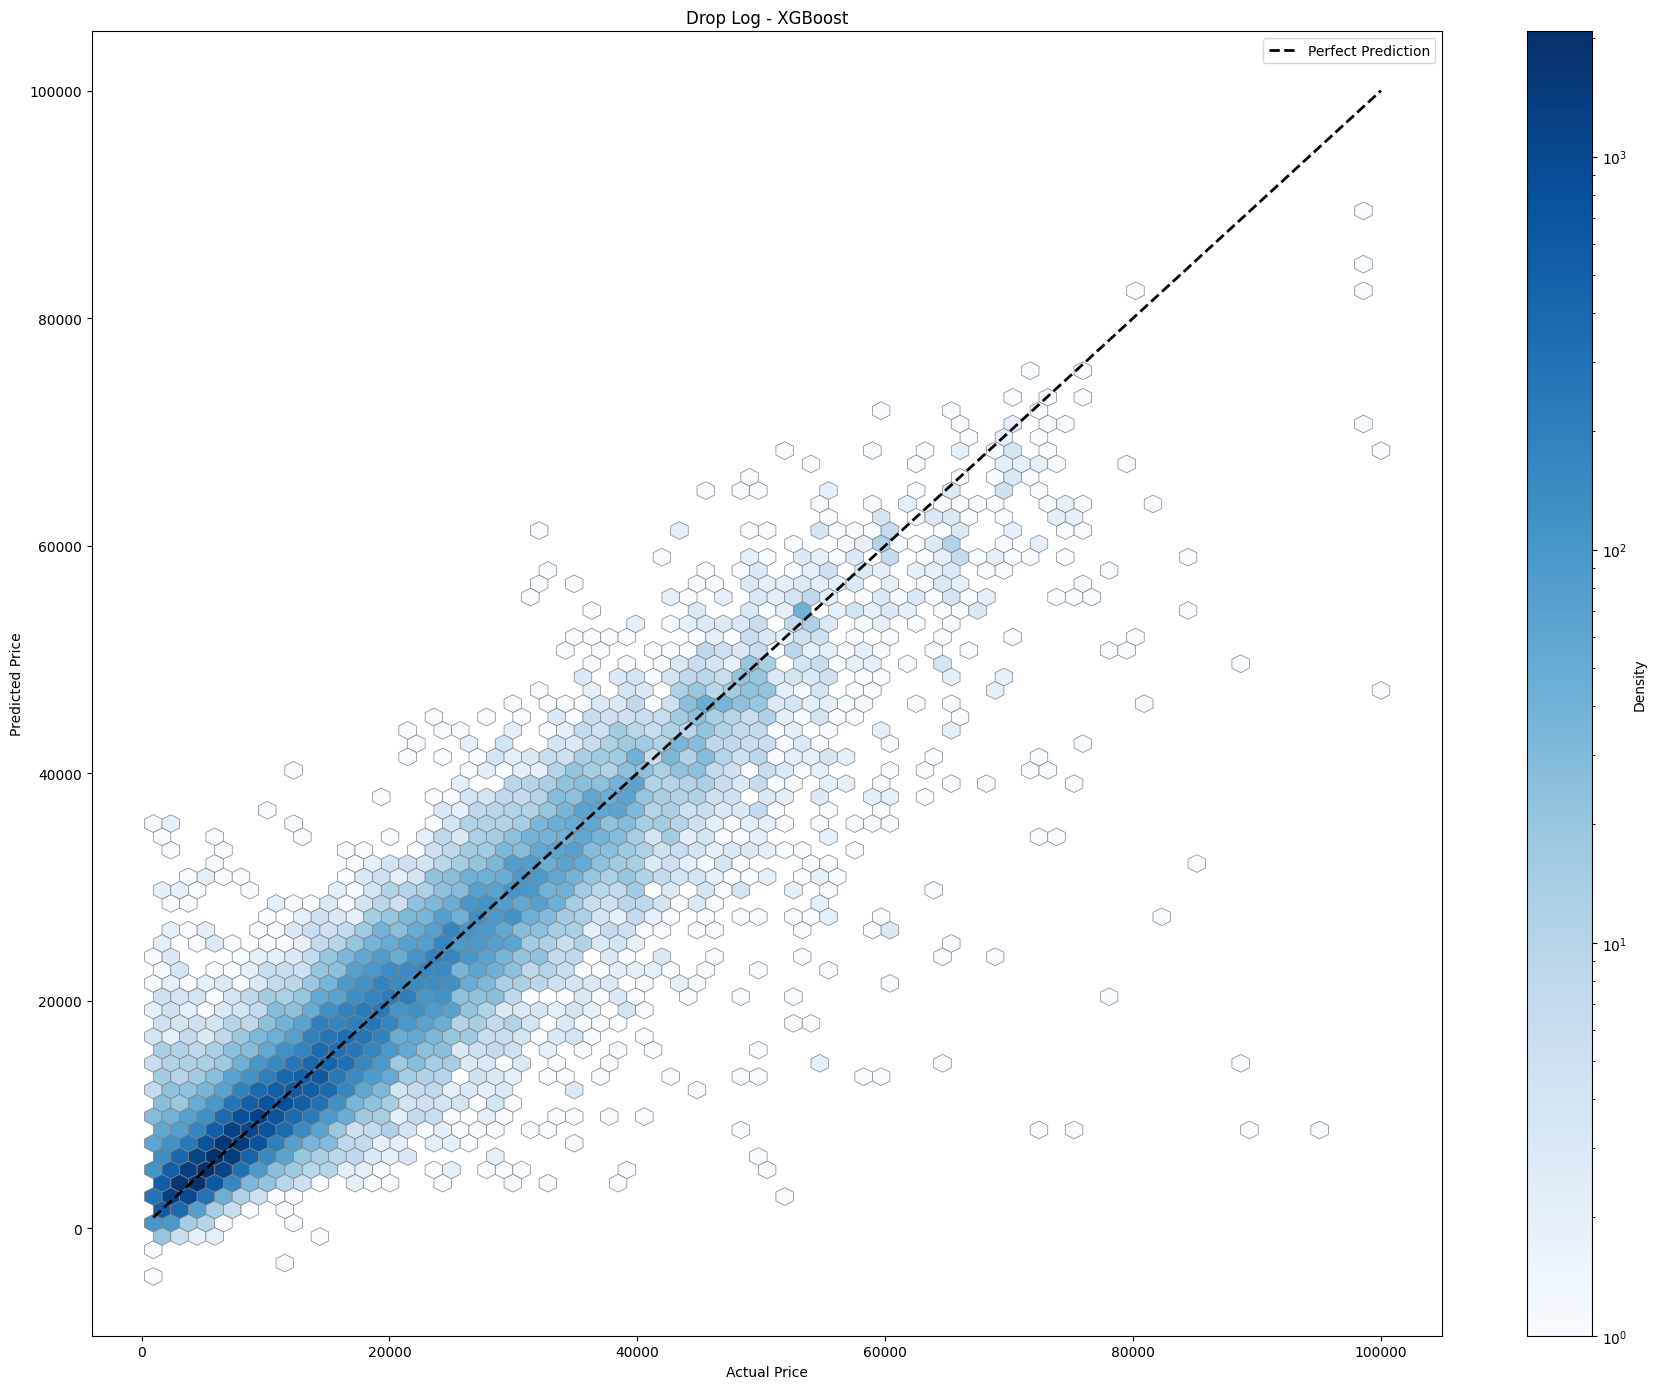

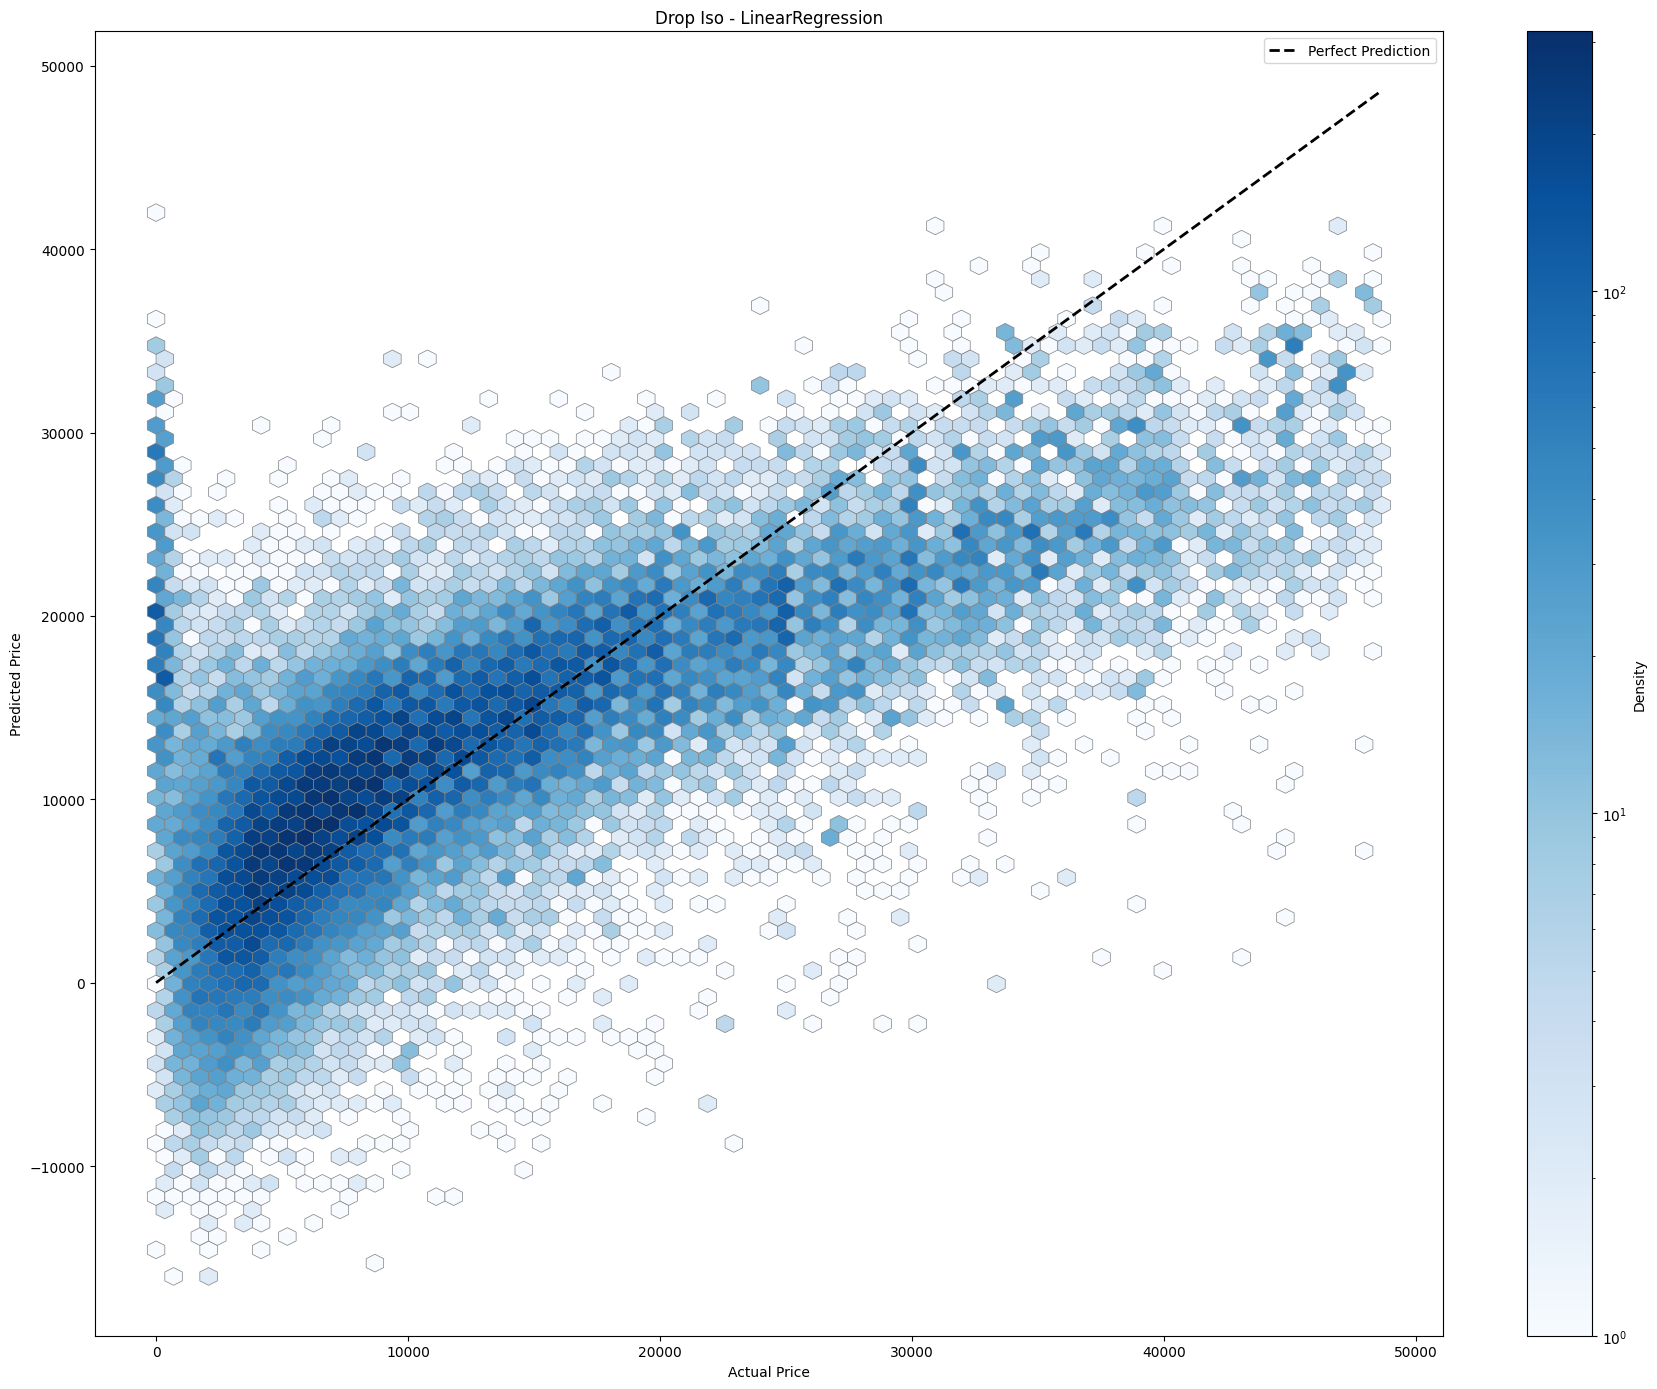

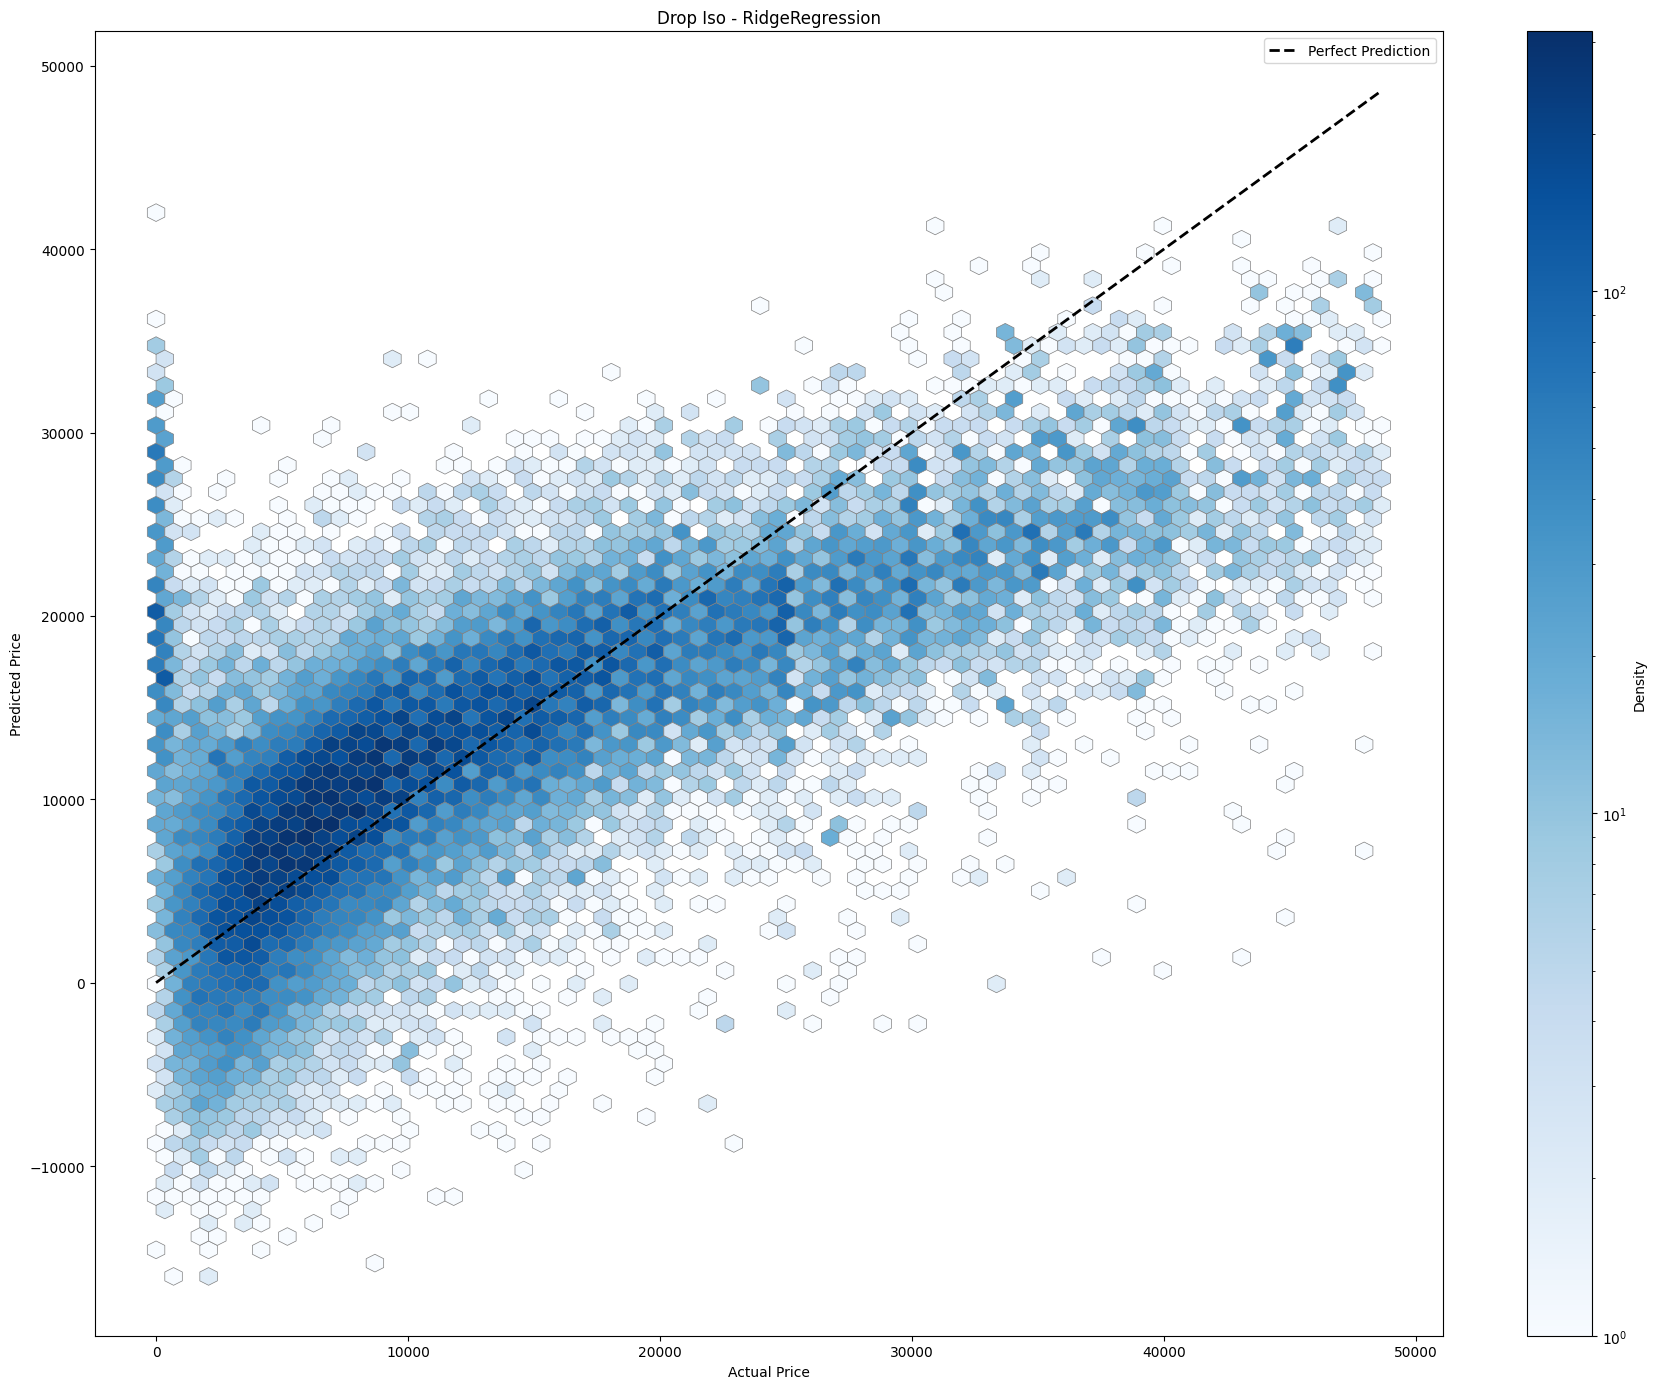

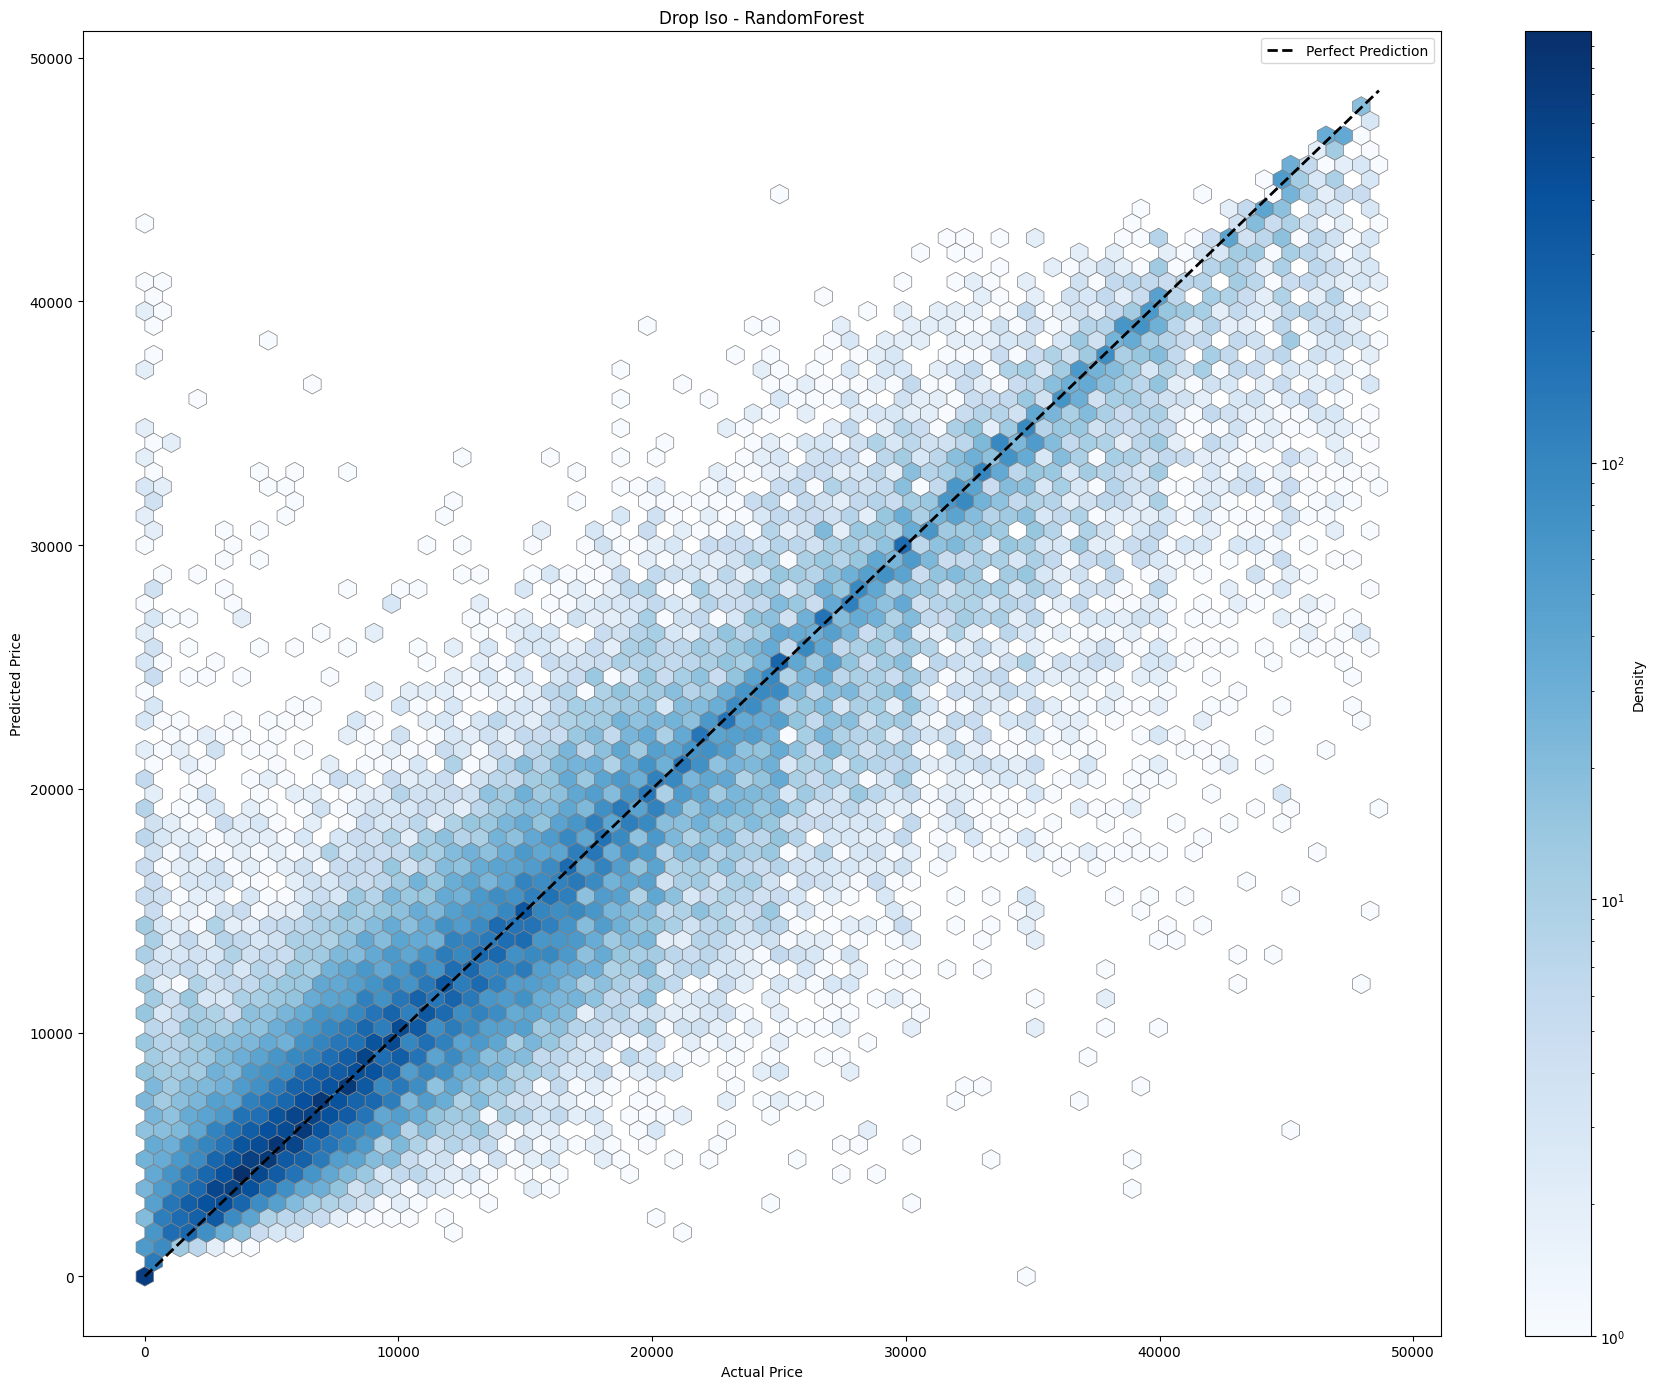

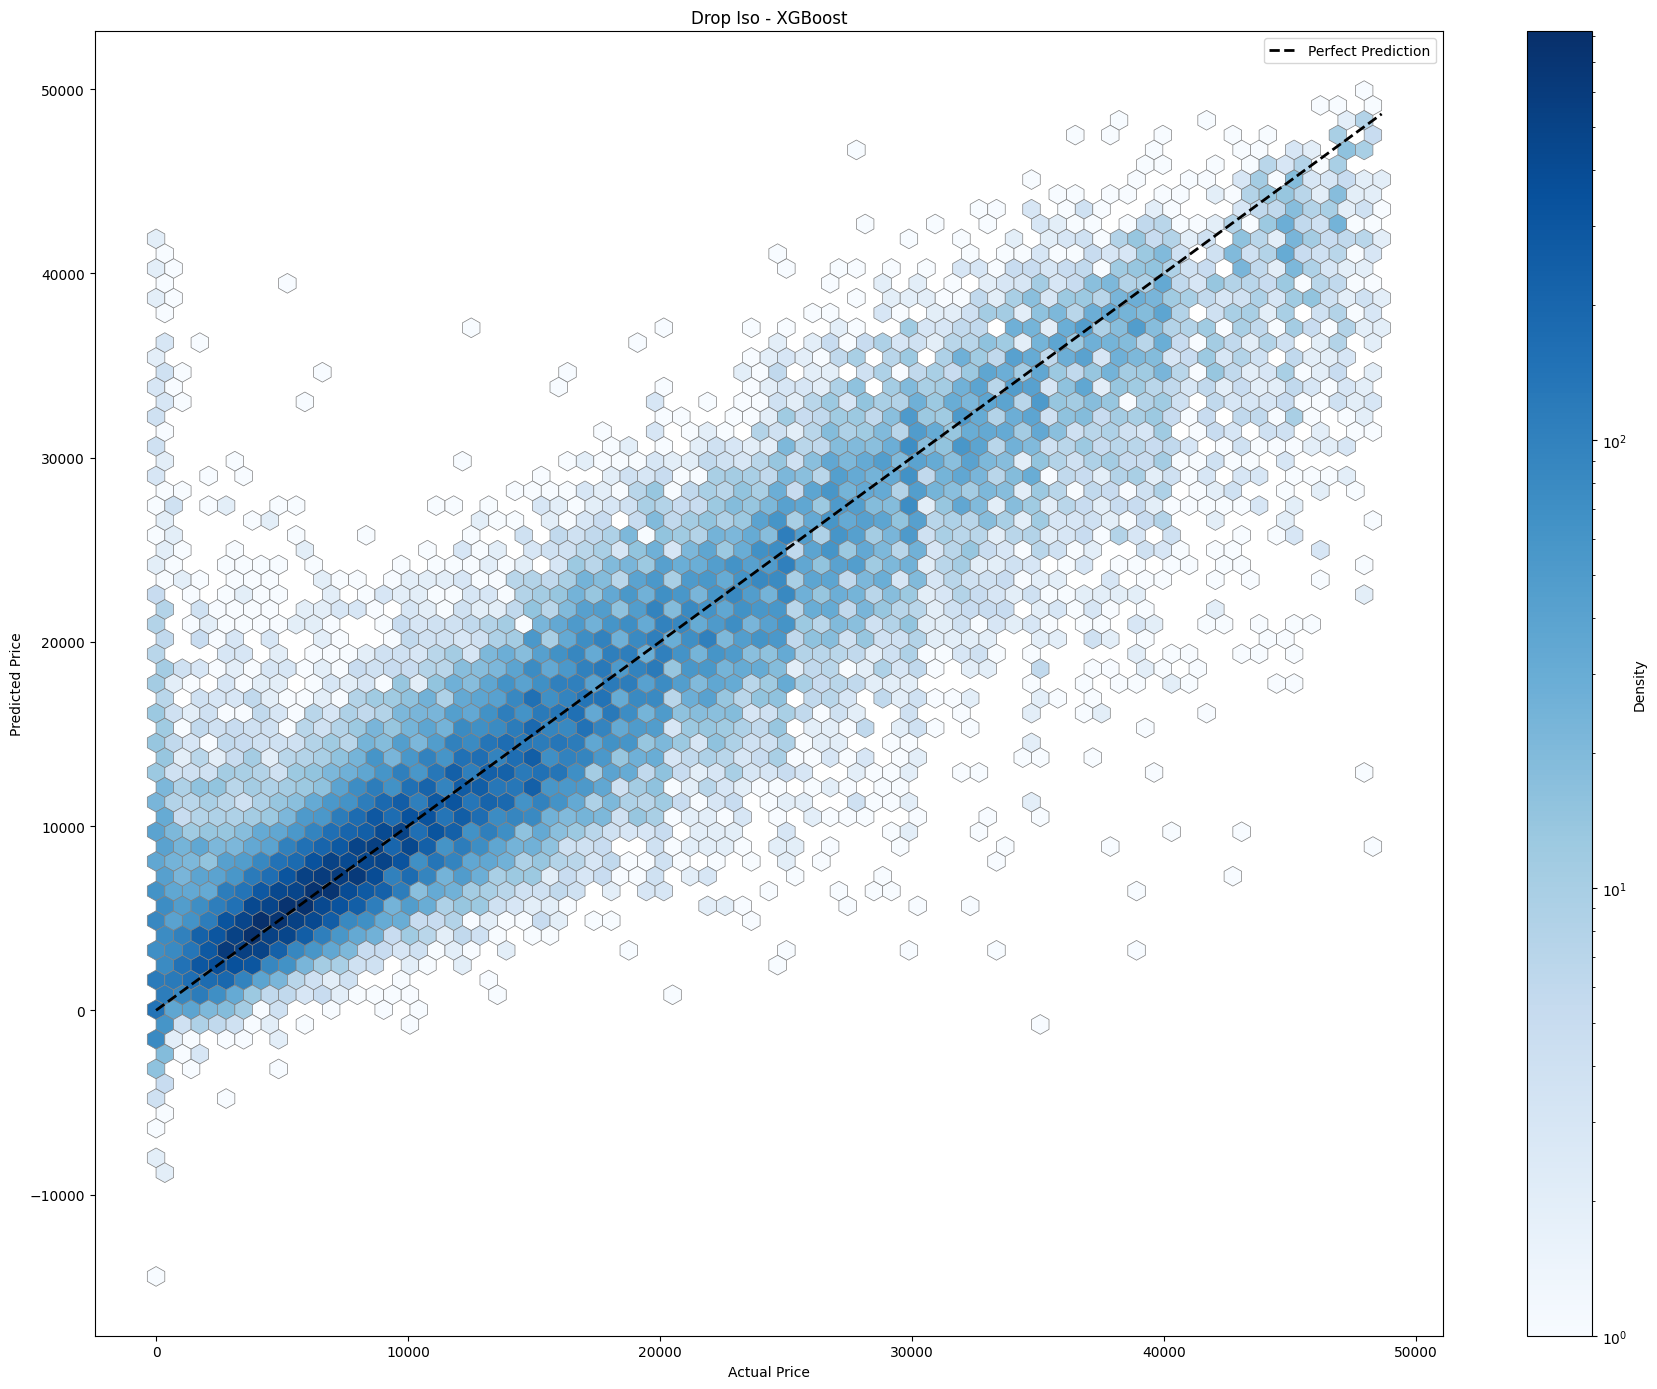

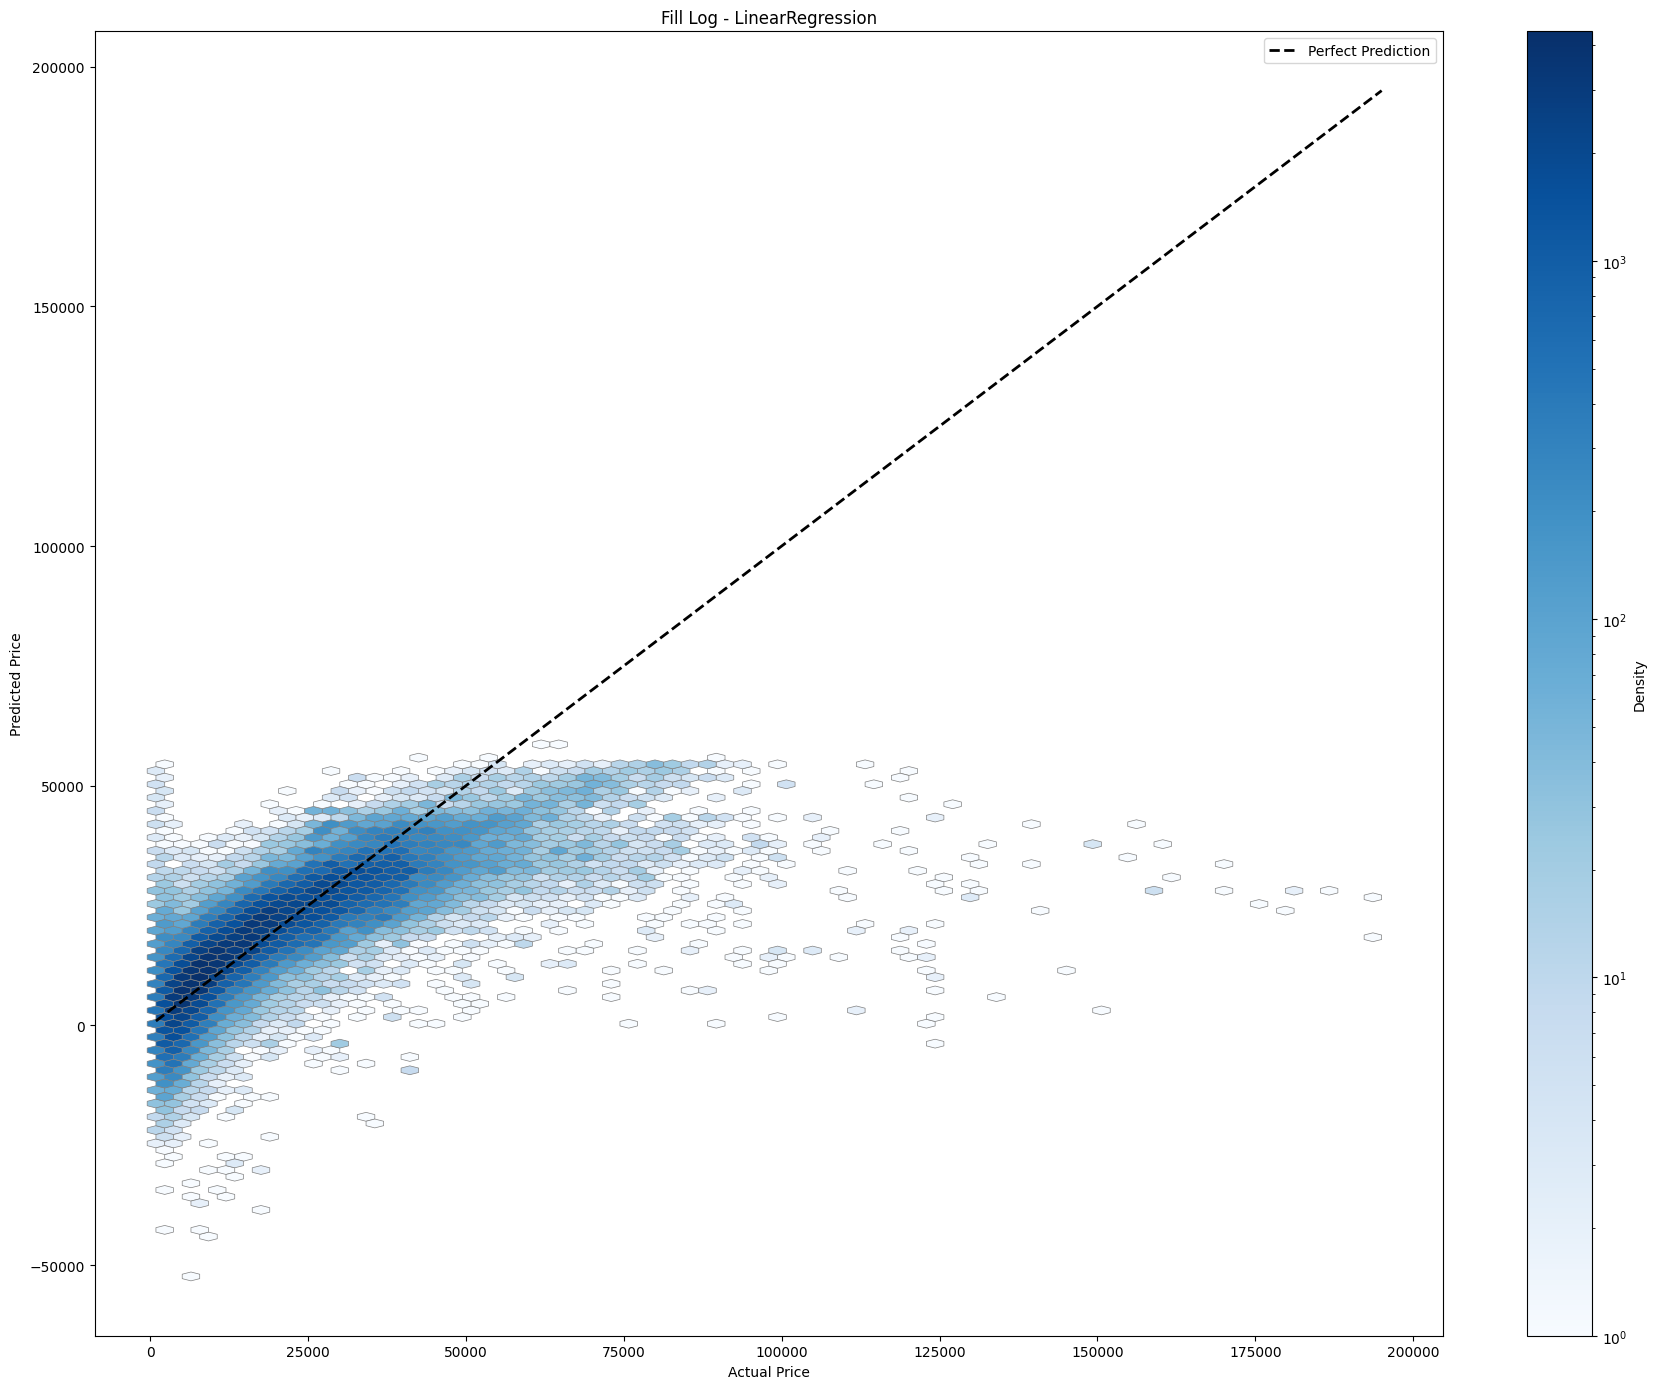

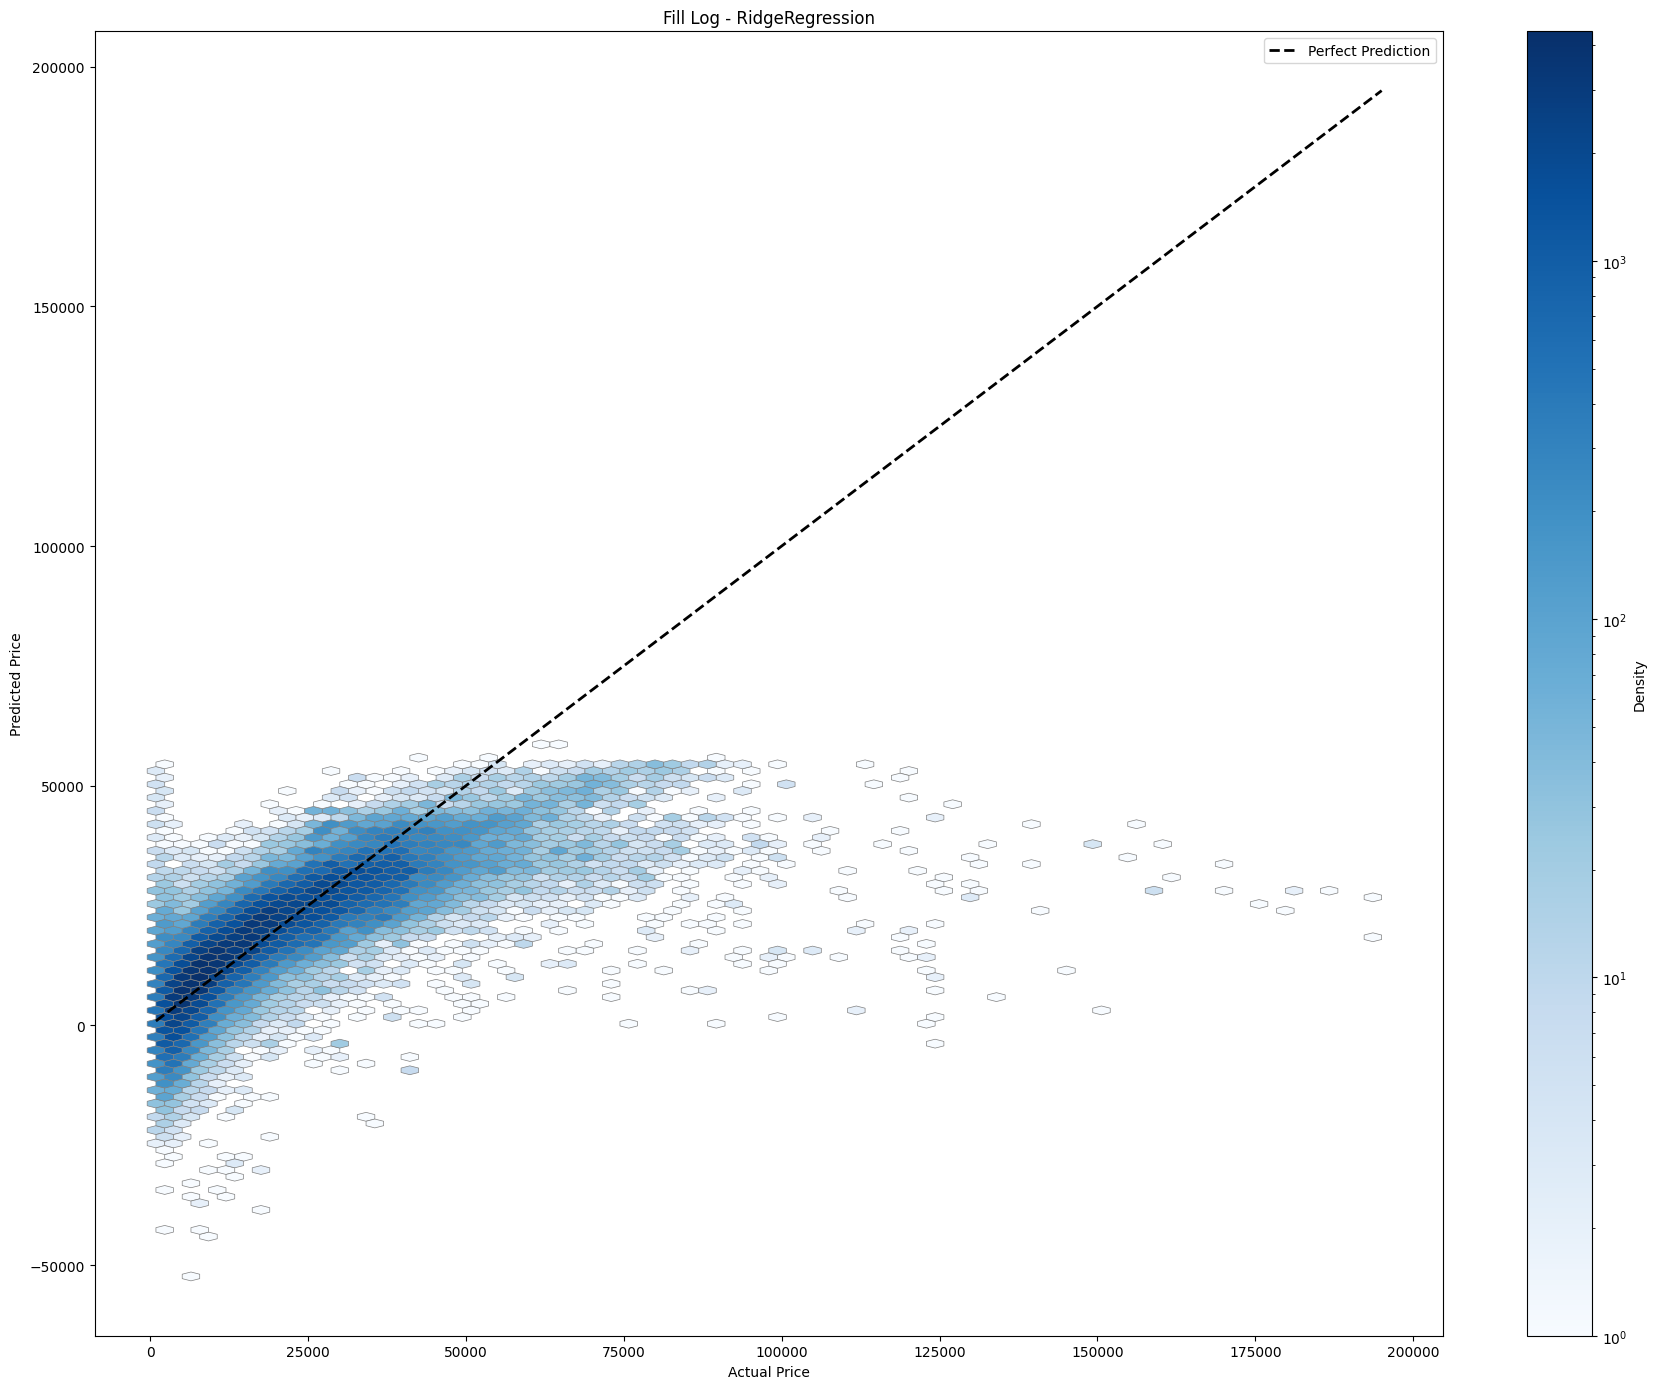

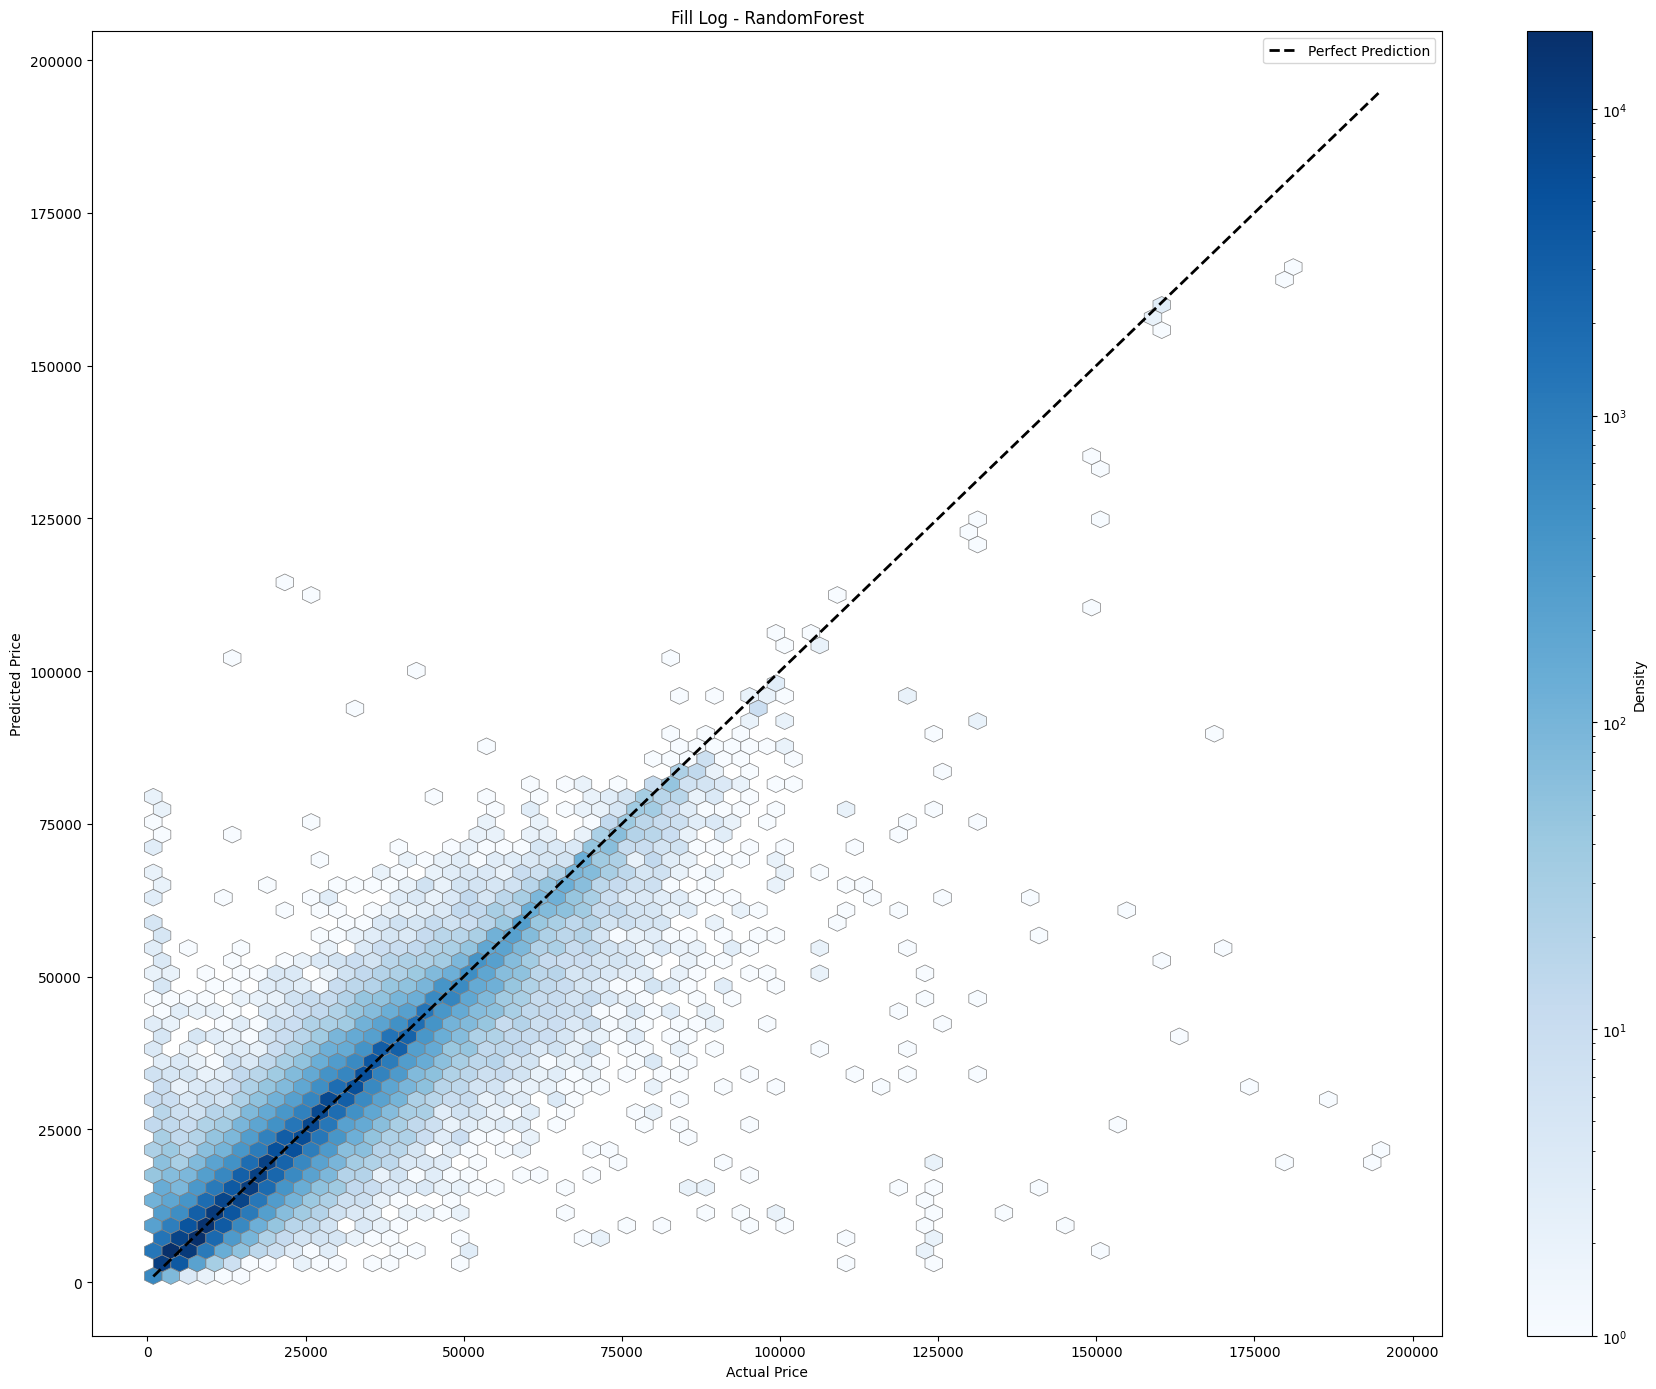

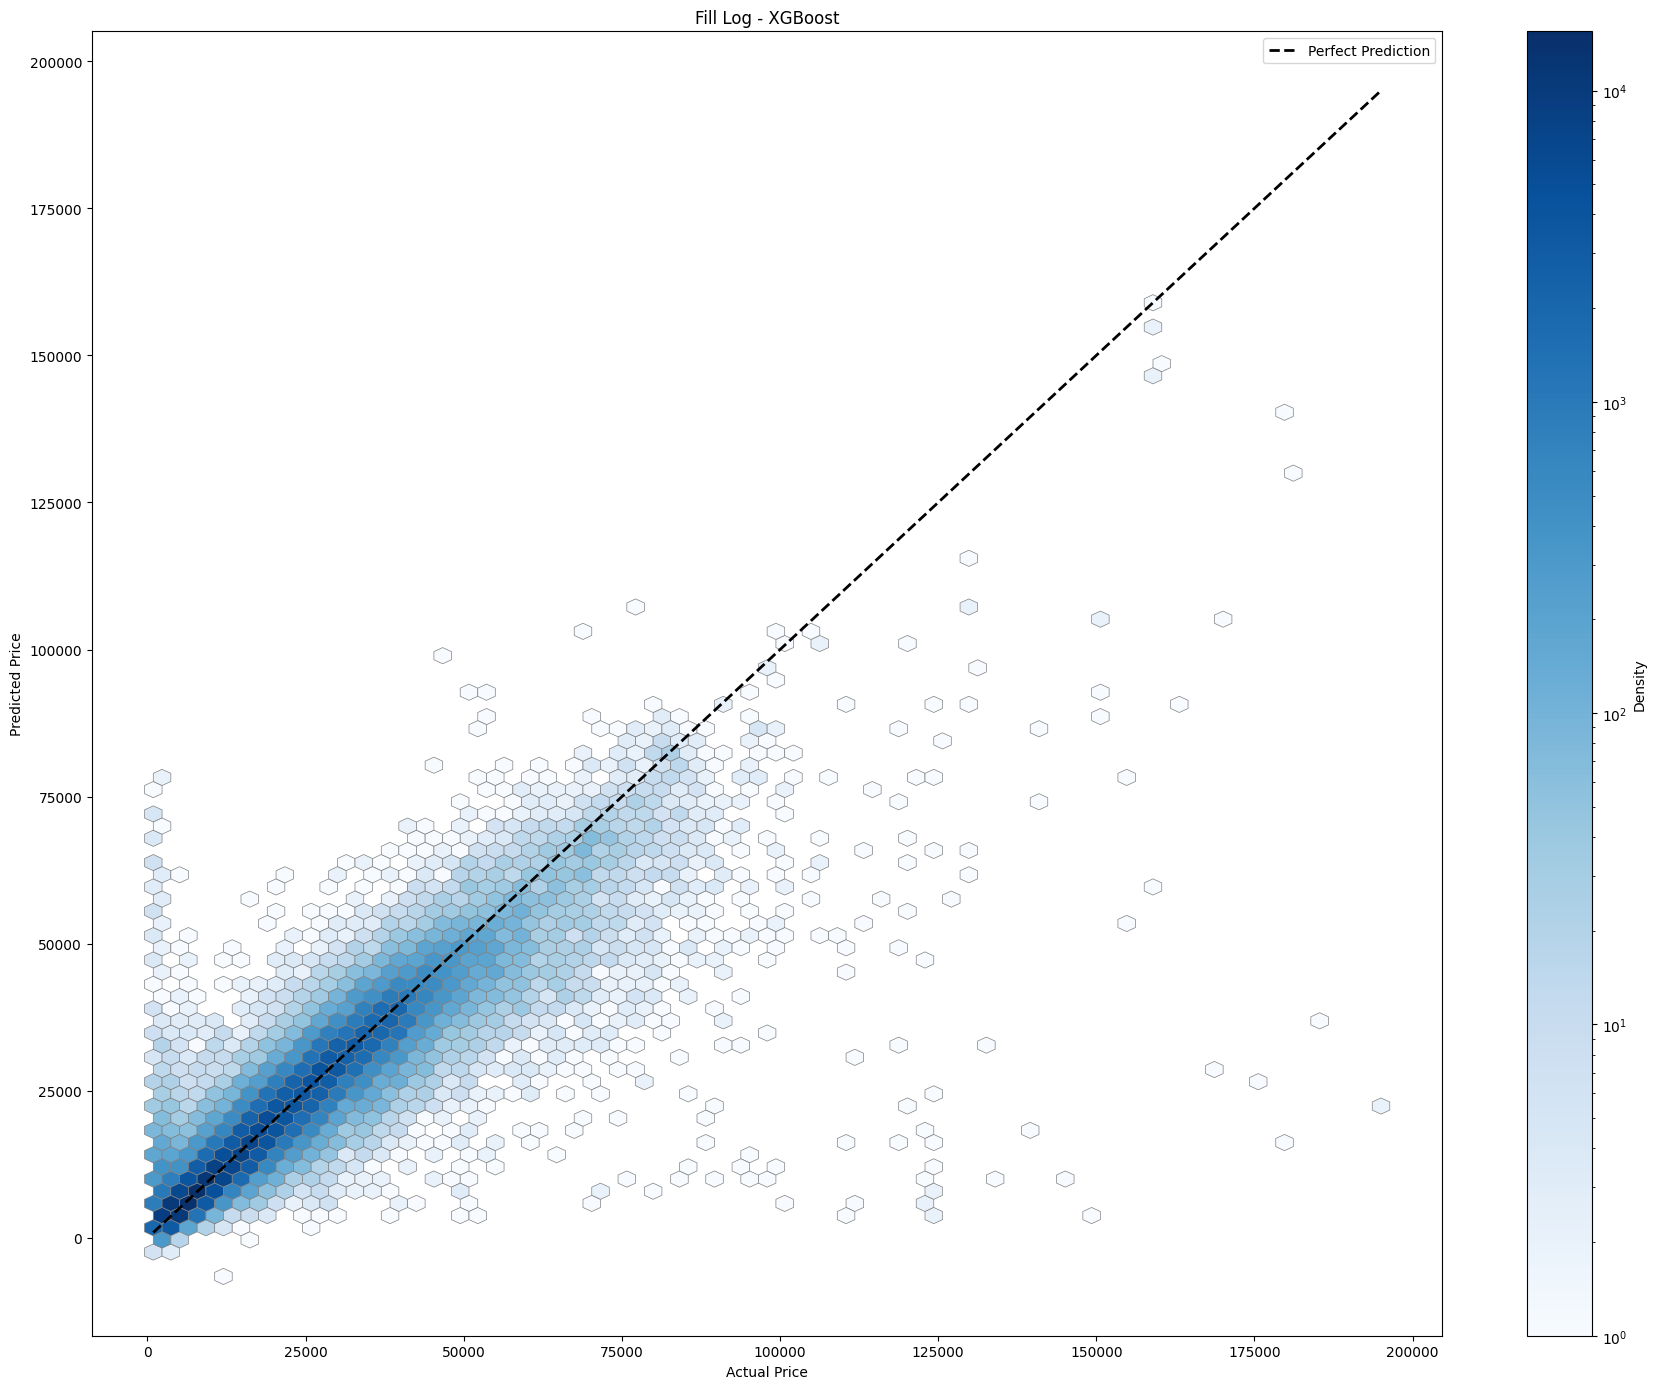

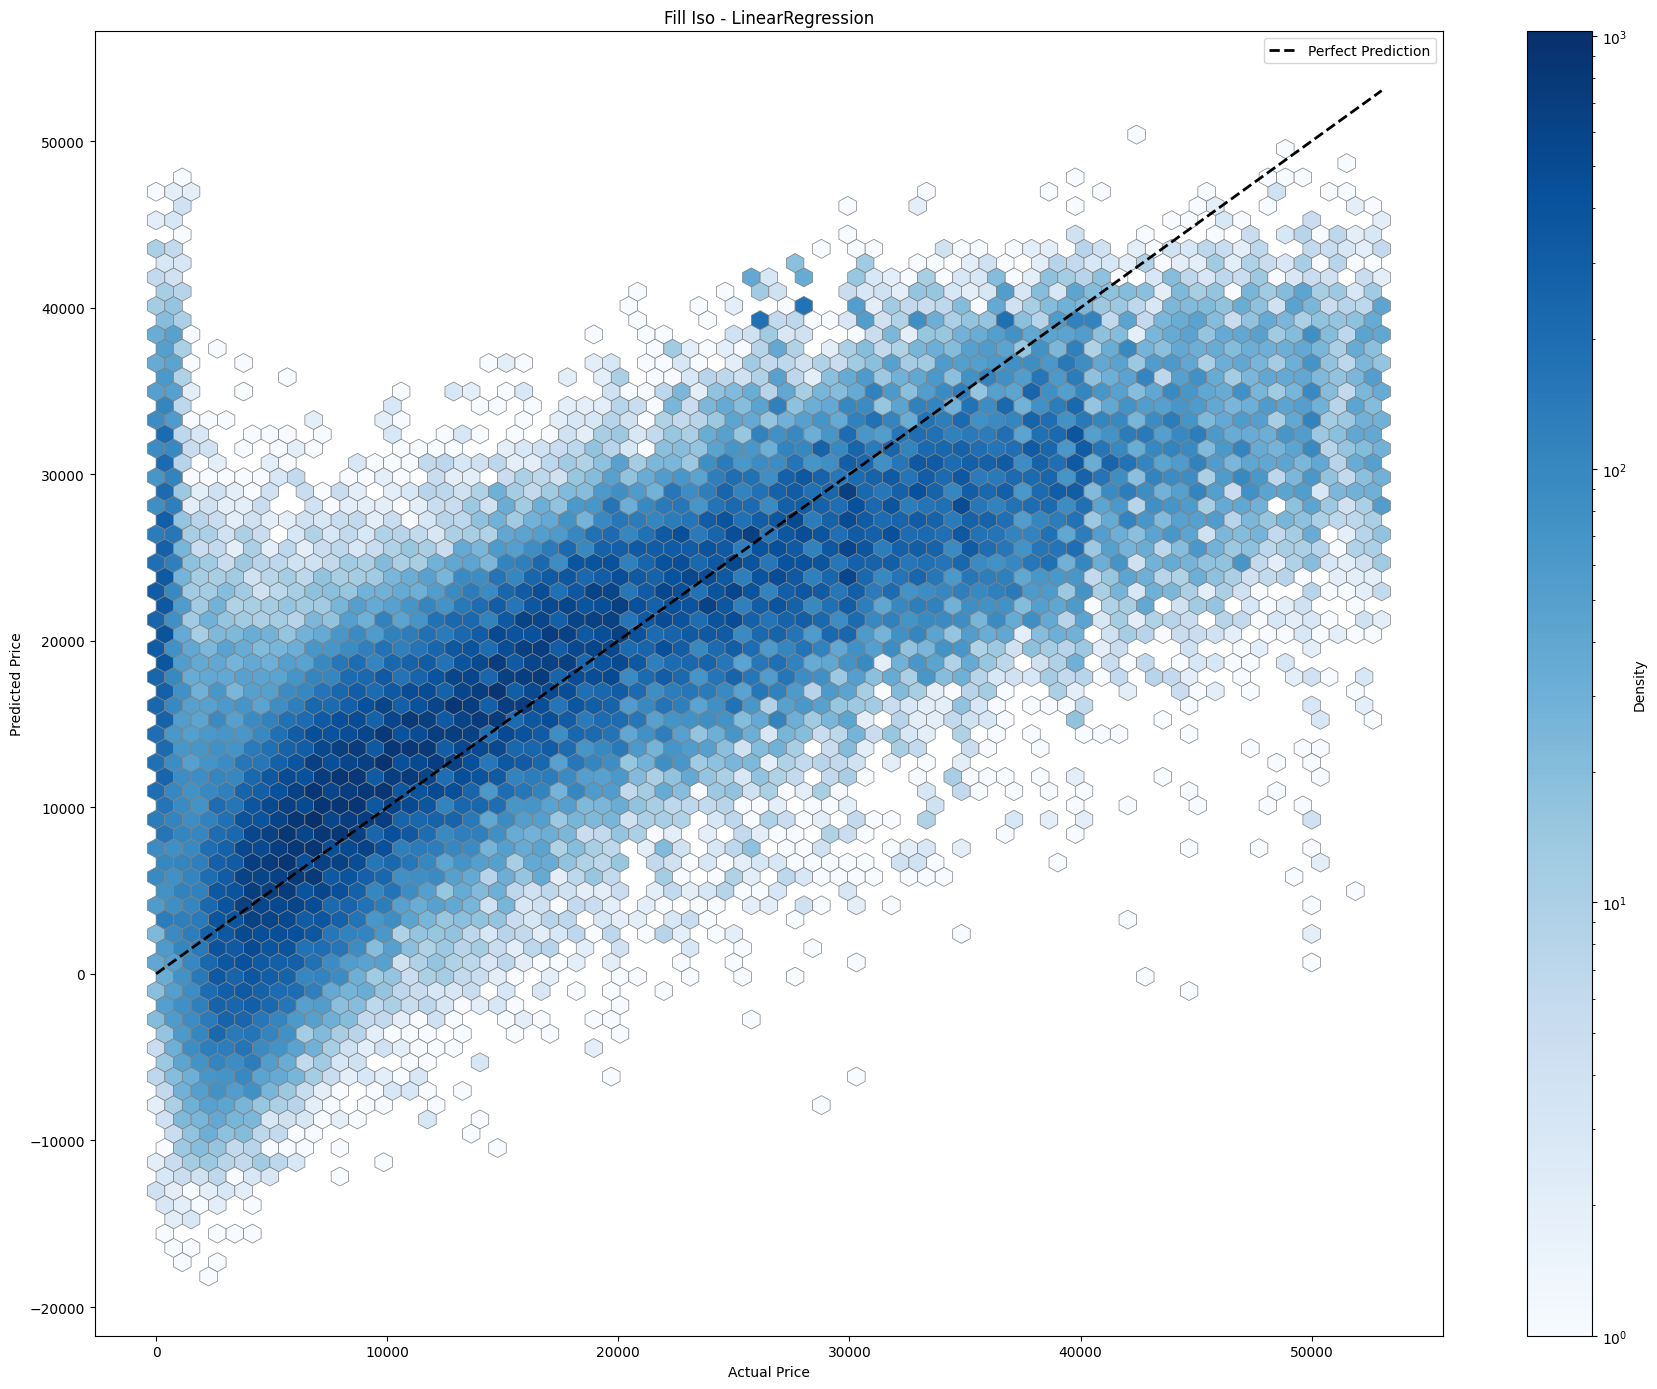

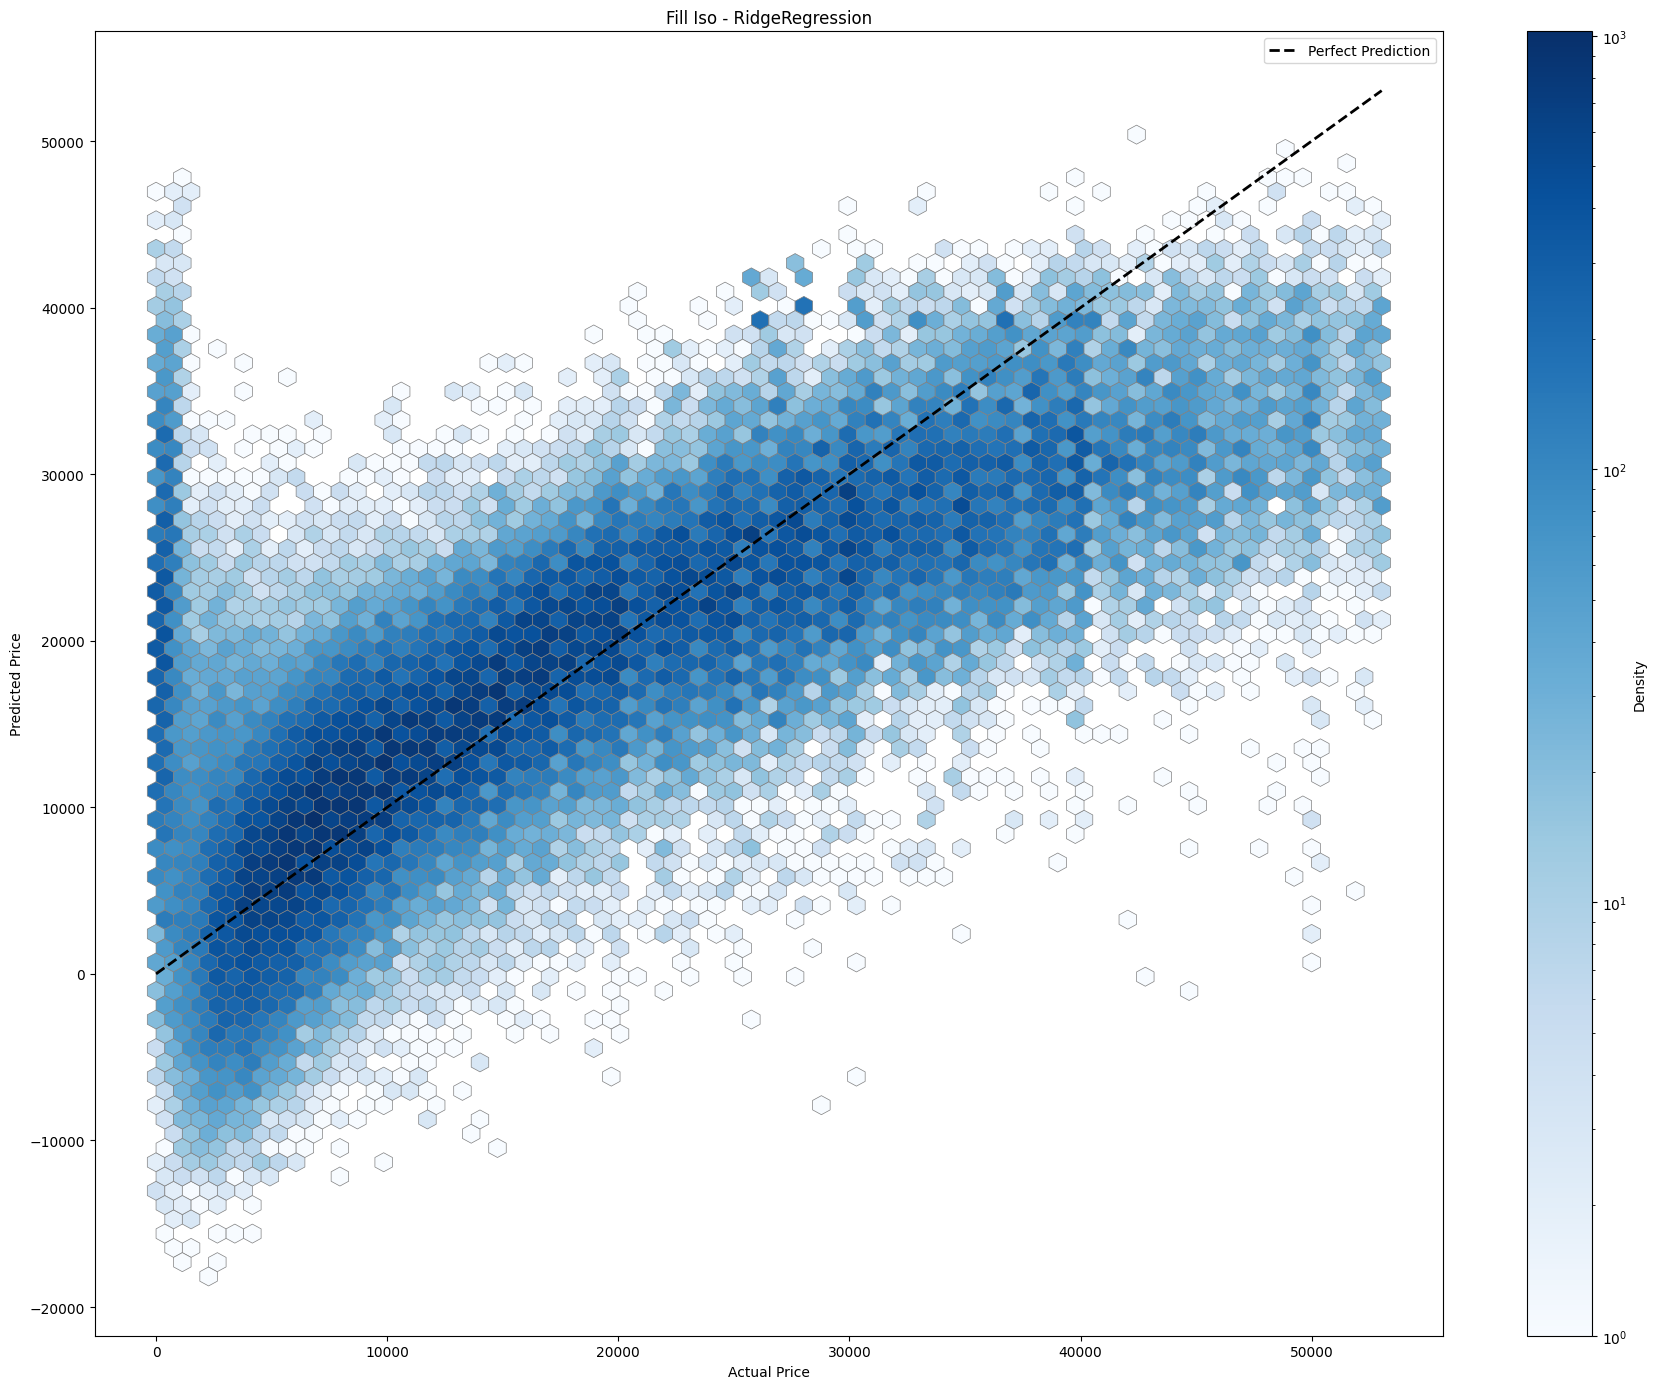

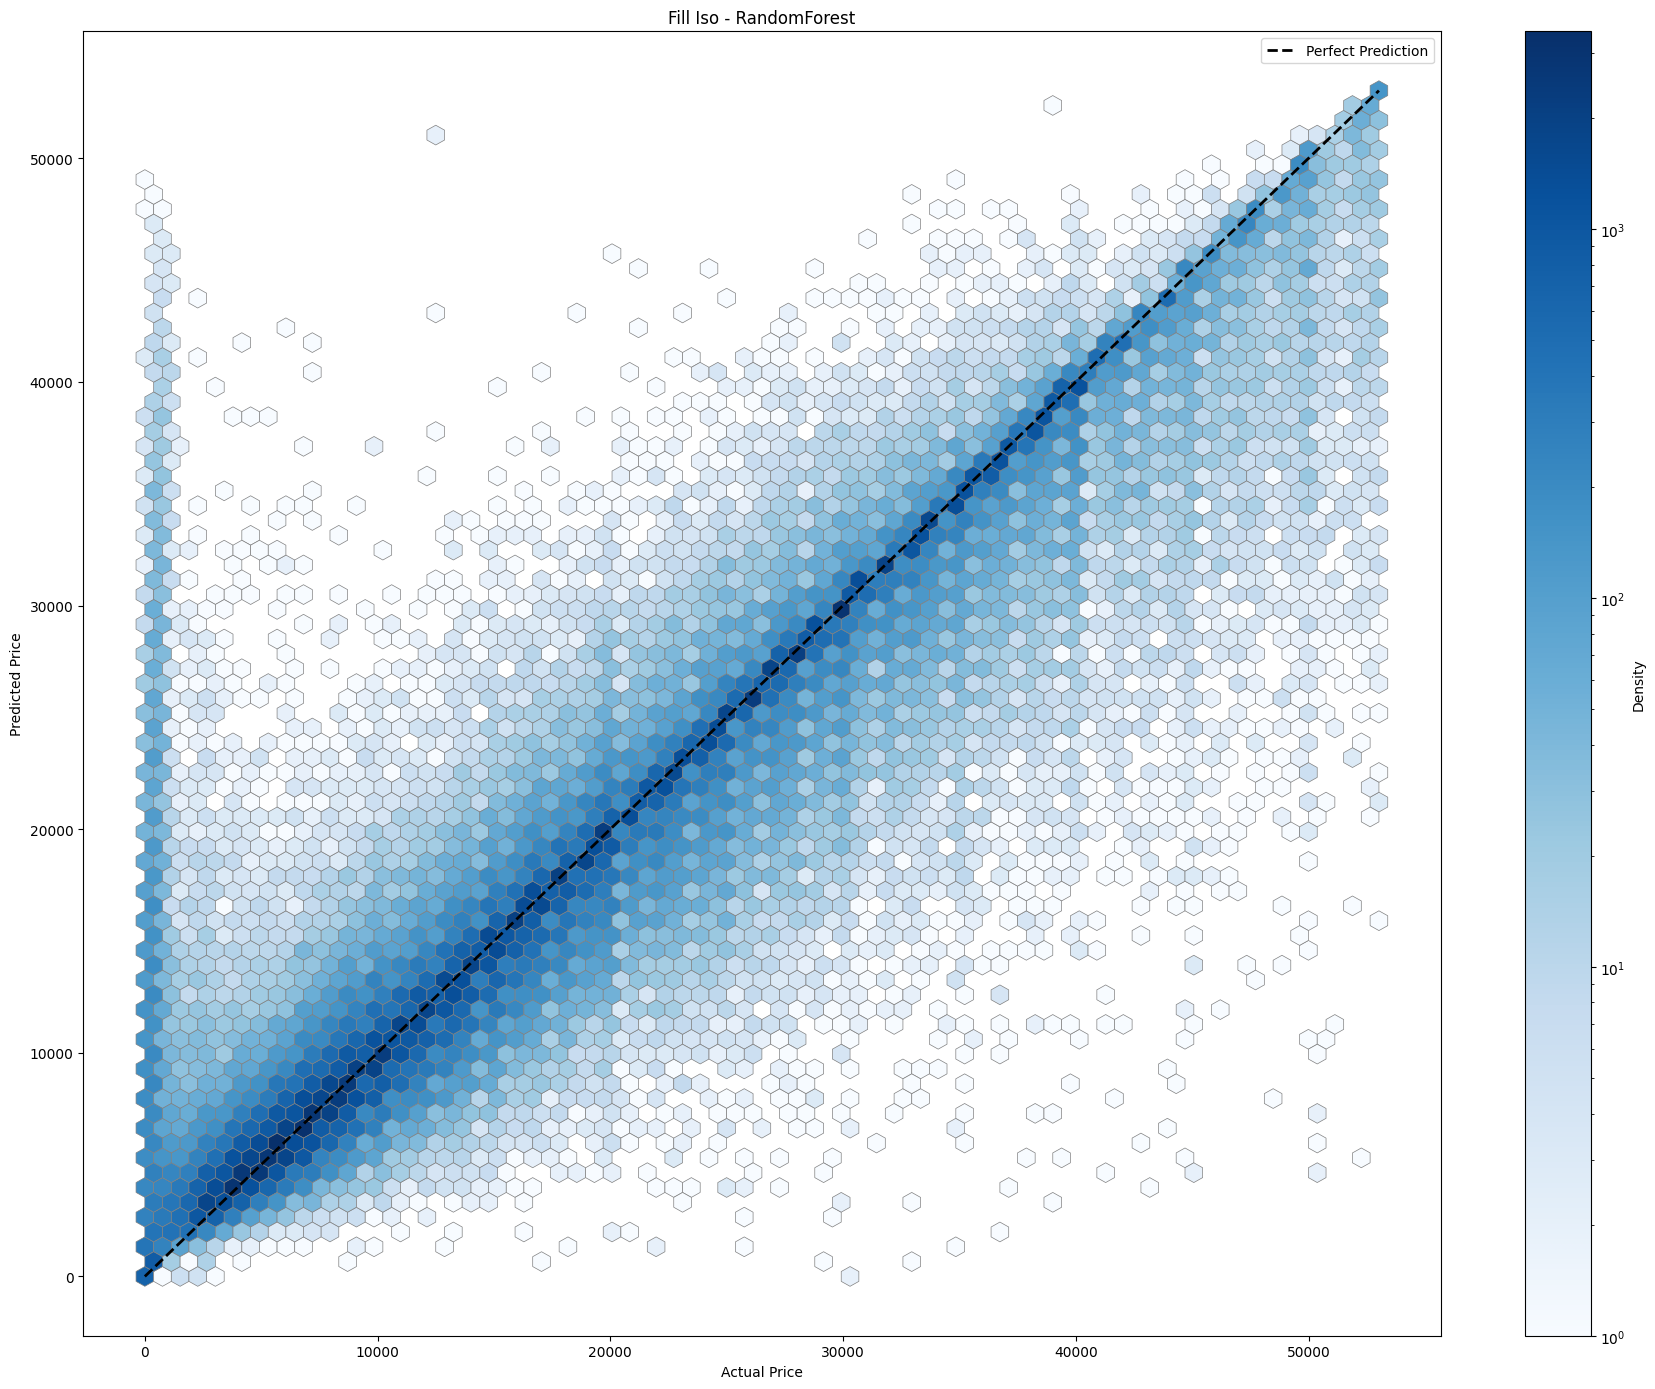

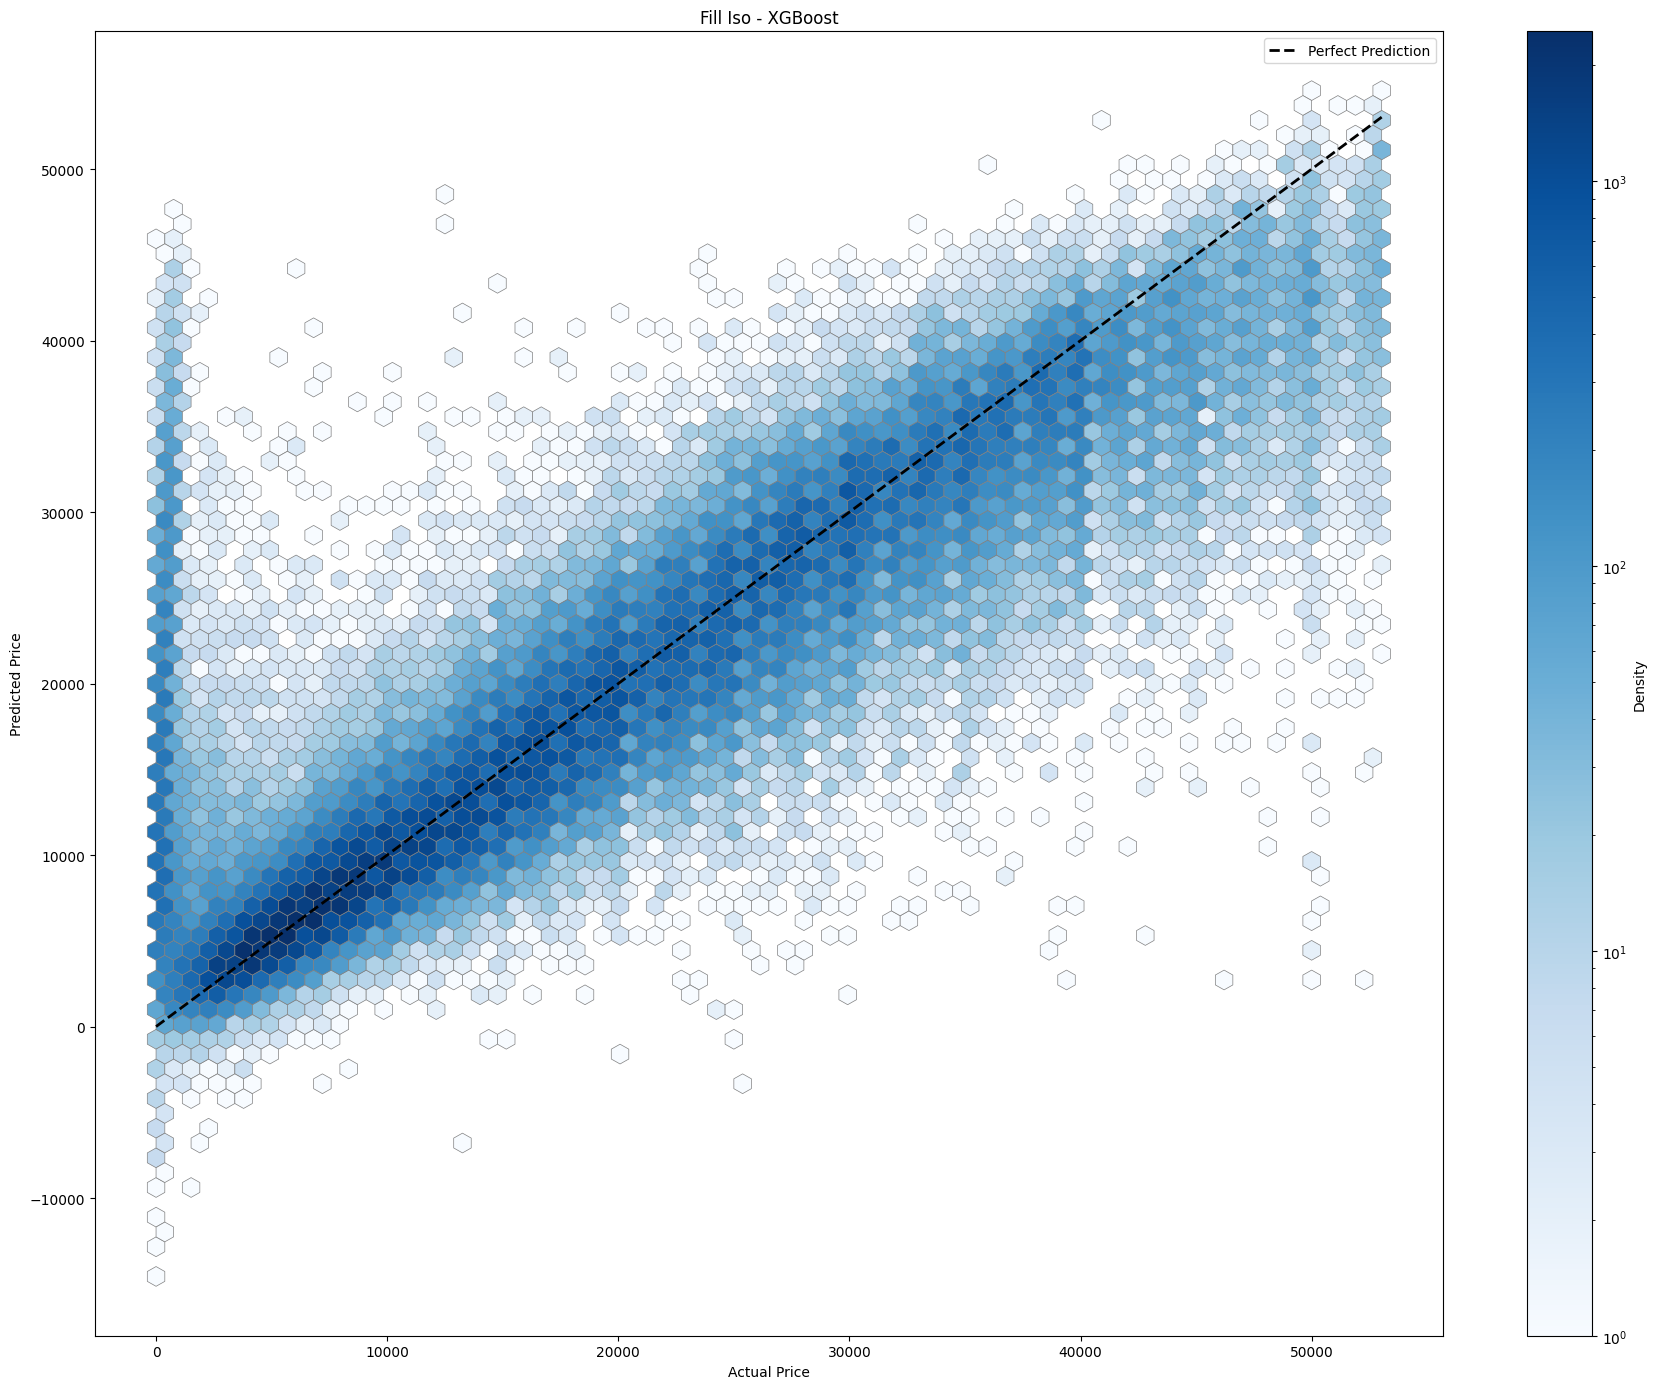

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

for result in results_no_hyper_tune:
    dataset_name = result["Dataset"]
    model_name = result["Model"]

    # Retrieve the corresponding dataset and model
    df = datasets[dataset_name]
    model = models[model_name]

    X = df.drop(columns=["price"])
    y = df["price"]

    # Generate predictions using cross_val_predict
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

    # Plot the results
    plt.figure(figsize=(18, 14))
    plt.hexbin(y, y_pred, gridsize=70, mincnt=1, linewidths=0.5, edgecolors='gray', cmap='Blues', bins='log')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{dataset_name} - {model_name}")
    plt.colorbar(label="Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


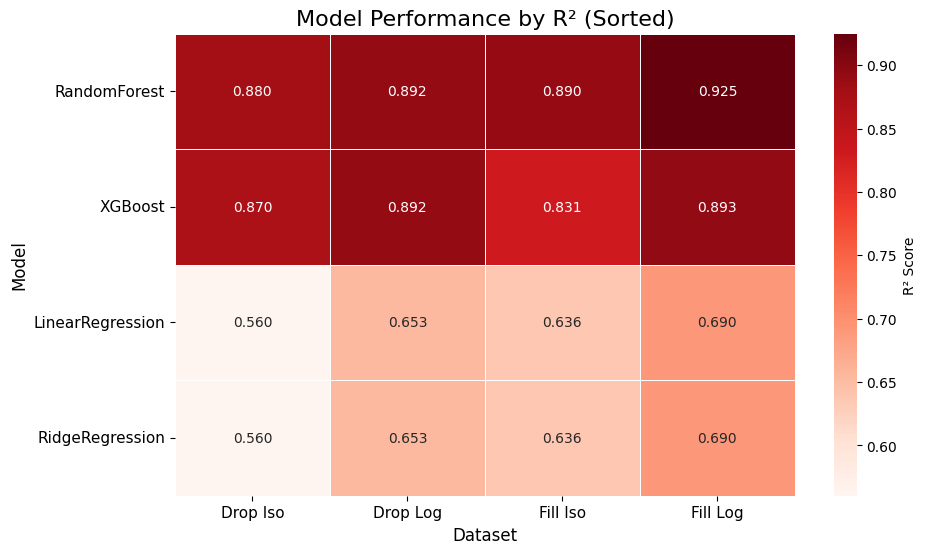

In [11]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_no_hyper_tune)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index="Model", columns="Dataset", values="R²")

# Calculate the average R² and sort by it
heatmap_data["Avg R²"] = heatmap_data.mean(axis=1)
heatmap_data.sort_values("Avg R²", ascending=False, inplace=True)
heatmap_data.drop(columns="Avg R²", inplace=True)

# Red theme color map
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="Reds",          # red theme
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "R² Score"}
)

plt.title("Model Performance by R² (Sorted)", fontsize=16)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [12]:
from sklearn.base import clone

# Prepare data
X_Fill = datasets["Fill Log"].drop(columns=["price"])
y_Fill = datasets["Fill Log"]["price"]

X_Drop = datasets["Drop Log"].drop(columns=["price"])
y_Drop = datasets["Drop Log"]["price"]

# Fit model
model = clone(models["RandomForest"]).fit(X, y)

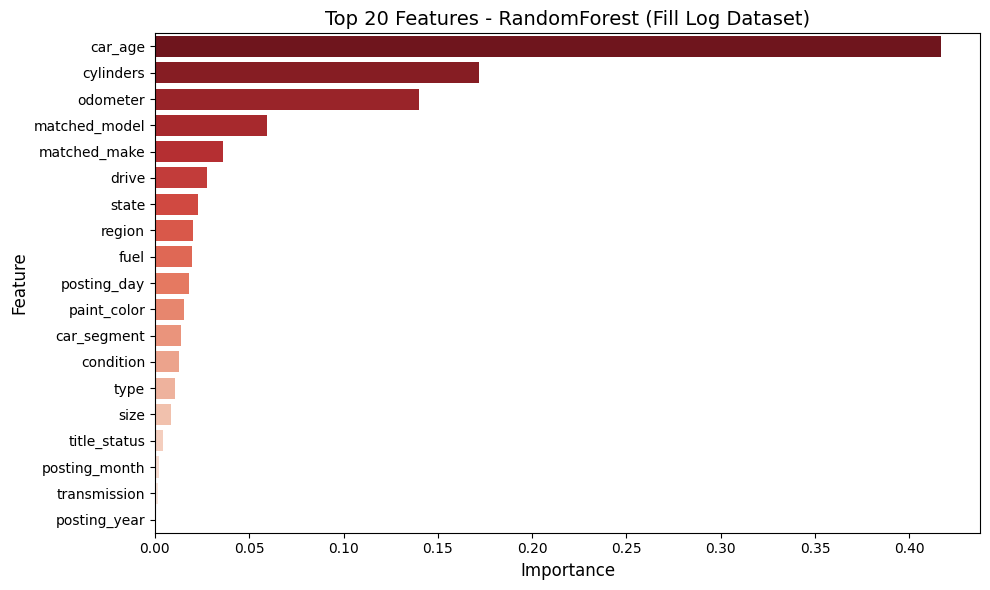

In [13]:
# Extract feature importances and select top 20
importances_fill = pd.Series(model.feature_importances_, index=X_Fill.columns).sort_values(ascending=False).head(20)

# Convert to DataFrame for seaborn
top_features_df = importances_fill.reset_index()
top_features_df.columns = ['Feature', 'Importance']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='Reds_r',
    dodge=False,
    legend=False  # hide redundant legend
)
plt.title("Top 20 Features - RandomForest (Fill Log Dataset)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

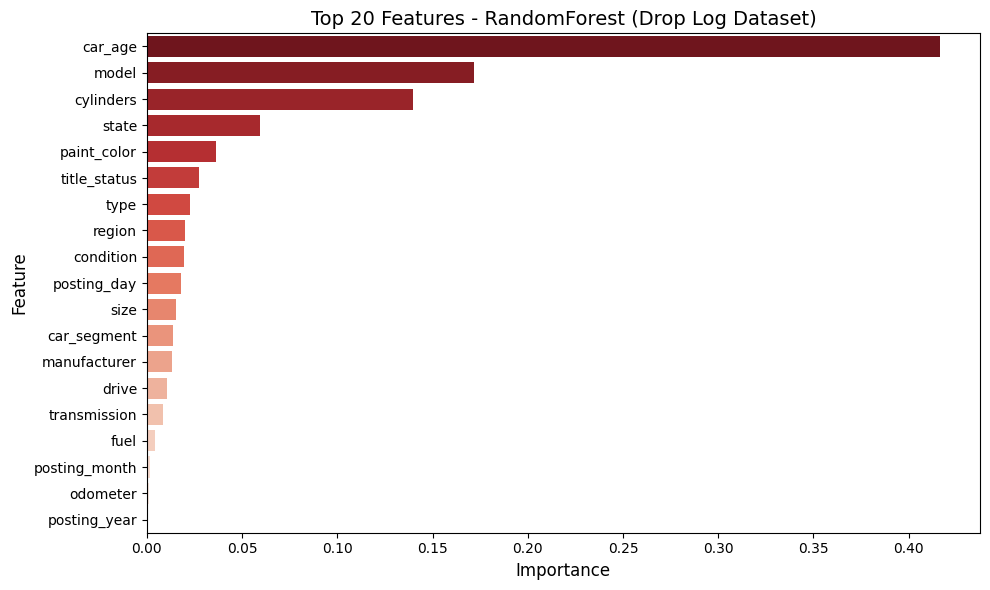

In [14]:
# Extract feature importances and select top 20
importances_drop = pd.Series(model.feature_importances_, index=X_Drop.columns).sort_values(ascending=False).head(20)

# Convert to DataFrame for seaborn
top_features_df = importances_drop.reset_index()
top_features_df.columns = ['Feature', 'Importance']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='Reds_r',
    dodge=False,
    legend=False  # hide redundant legend
)
plt.title("Top 20 Features - RandomForest (Drop Log Dataset)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

note : redundency on car_age and year drop `year`

In [15]:
importances_fill * 100

car_age          41.658839
cylinders        17.175320
odometer         13.975871
matched_model     5.918651
matched_make      3.609138
drive             2.746318
state             2.271654
region            1.993686
fuel              1.976838
posting_day       1.789746
paint_color       1.548390
car_segment       1.366275
condition         1.300085
type              1.057283
size              0.836411
title_status      0.442145
posting_month     0.193731
transmission      0.139621
posting_year      0.000000
dtype: float64

In [16]:
importances_drop * 100

car_age          41.658839
model            17.175320
cylinders        13.975871
state             5.918651
paint_color       3.609138
title_status      2.746318
type              2.271654
region            1.993686
condition         1.976838
posting_day       1.789746
size              1.548390
car_segment       1.366275
manufacturer      1.300085
drive             1.057283
transmission      0.836411
fuel              0.442145
posting_month     0.193731
odometer          0.139621
posting_year      0.000000
dtype: float64

In [17]:
select_feature_fill = importances_fill[:8].index
select_feature_fill

Index(['car_age', 'cylinders', 'odometer', 'matched_model', 'matched_make',
       'drive', 'state', 'region'],
      dtype='object')

In [18]:
select_feature_drop = importances_drop[:8].index
select_feature_drop

Index(['car_age', 'model', 'cylinders', 'state', 'paint_color', 'title_status',
       'type', 'region'],
      dtype='object')

In [19]:
importances_fill[select_feature_fill].sum()

np.float64(0.8934947562695974)

In [20]:
importances_drop[select_feature_drop].sum()

np.float64(0.8934947562695974)

## 🛠️Feature Selection & Hypertune

In [21]:
datasets = {
    "Drop Log Selected": datasets["Drop Log"][select_feature_drop.tolist() + ['price']].copy(),
    "Drop Iso Selected": datasets["Drop Iso"][select_feature_drop.tolist() + ['price']].copy(),
    "Fill Log Selected": datasets["Fill Log"][select_feature_fill.tolist() + ['price']].copy(),
    "Fill Iso Selected": datasets["Fill Iso"][select_feature_fill.tolist() + ['price']].copy()
}

In [22]:
import optuna

class EarlyStoppingCallback:
    def __init__(self, patience):
        self.patience = patience
        self.best_value = float('inf')
        self.counter = 0

    def __call__(self, study, trial):
        if study.best_value < self.best_value:
            self.best_value = study.best_value
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f"⛔️ Early stopping triggered after {self.patience} trials.")
            study.stop()

In [23]:
# --- Tuning functions ---
def tune_ridge(trial, X, y):
    alpha = trial.suggest_float("alpha", 0.01, 100.0, log=True)
    model = Ridge(alpha=alpha)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 

def tune_rf(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5)
    }
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 

def tune_xgb(trial, X, y):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    model = XGBRegressor(**params, n_jobs=-1, random_state=42, verbosity=0)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 

In [24]:
# --- Main loop ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_tuned = []
best_params = {}

for dataset_name, df in datasets.items():
    X = df.drop(columns=["price"])
    y = df["price"]

    for model_name in ["RidgeRegression", "RandomForest", "XGBoost"]:
        def objective(trial):
            if model_name == "RidgeRegression":
                return tune_ridge(trial, X, y)
            elif model_name == "RandomForest":
                return tune_rf(trial, X, y)
            elif model_name == "XGBoost":
                return tune_xgb(trial, X, y)
            
        early_stopping = EarlyStoppingCallback(patience=30 if model_name == "RidgeRegression" else 6)

        # --- Inside loop ---
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials = 100 if model_name == "RidgeRegression" else 25, callbacks=[early_stopping])

        best_params[(dataset_name, model_name)] = study.best_params

        # Retrain with best params
        if model_name == "RidgeRegression":
            model = Ridge(**study.best_params)
        elif model_name == "RandomForest":
            model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
        elif model_name == "XGBoost":
            model = XGBRegressor(**study.best_params, random_state=42, n_jobs=-1, verbosity=0)

        y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

        # Inverse log if needed
        y_true = np.expm1(y) if dataset_name == "Log" else y
        y_pred = np.expm1(y_pred) if dataset_name == "Log" else y_pred

        r2, rmse, mae, pmae = evaluate(y_true, y_pred)
        results_tuned.append({
            "Dataset": dataset_name,
            "Model": model_name + " (Tuned)",
            "R²": round(r2, 4),
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "PMAE (%)": round(pmae, 2)
        })

[I 2025-05-11 07:31:31,280] A new study created in memory with name: no-name-150d2e10-974a-4d8d-816e-b1f448dd5c38
[I 2025-05-11 07:31:31,501] Trial 0 finished with value: 4060132216494.703 and parameters: {'alpha': 0.4692333616198267}. Best is trial 0 with value: 4060132216494.703.
[I 2025-05-11 07:31:31,687] Trial 1 finished with value: 4060132217739.0933 and parameters: {'alpha': 0.26049864305527726}. Best is trial 0 with value: 4060132216494.703.
[I 2025-05-11 07:31:31,910] Trial 2 finished with value: 4060132218081.756 and parameters: {'alpha': 0.2034168198582575}. Best is trial 0 with value: 4060132216494.703.
[I 2025-05-11 07:31:32,440] Trial 3 finished with value: 4060132218758.6187 and parameters: {'alpha': 0.09115598066556847}. Best is trial 0 with value: 4060132216494.703.
[I 2025-05-11 07:31:32,624] Trial 4 finished with value: 4060132204771.311 and parameters: {'alpha': 2.5614954097318825}. Best is trial 4 with value: 4060132204771.311.
[I 2025-05-11 07:31:32,804] Trial 5 f

⛔️ Early stopping triggered after 30 trials.


[I 2025-05-11 07:31:39,468] A new study created in memory with name: no-name-c86a87e6-6dec-4c49-92f5-432facfbc3f2
[I 2025-05-11 07:31:53,933] Trial 0 finished with value: 1627541152710.2393 and parameters: {'n_estimators': 386, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 1627541152710.2393.
[I 2025-05-11 07:32:16,131] Trial 1 finished with value: 1352427877055.692 and parameters: {'n_estimators': 385, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 1352427877055.692.
[I 2025-05-11 07:32:21,519] Trial 2 finished with value: 1499856804340.2227 and parameters: {'n_estimators': 117, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 1352427877055.692.
[I 2025-05-11 07:32:40,283] Trial 3 finished with value: 1343573012652.8528 and parameters: {'n_estimators': 305, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 3 with value: 1

⛔️ Early stopping triggered after 6 trials.


[I 2025-05-11 07:34:12,821] A new study created in memory with name: no-name-96a08bf7-b35e-4694-8489-676a4b81cf82
[I 2025-05-11 07:34:15,529] Trial 0 finished with value: 1291967195587.5347 and parameters: {'learning_rate': 0.20435297747961023, 'n_estimators': 292, 'max_depth': 7, 'subsample': 0.7642462420052377, 'colsample_bytree': 0.7796861705375566}. Best is trial 0 with value: 1291967195587.5347.
[I 2025-05-11 07:34:20,733] Trial 1 finished with value: 1433943923948.6843 and parameters: {'learning_rate': 0.2714457575218403, 'n_estimators': 257, 'max_depth': 10, 'subsample': 0.5453560912984676, 'colsample_bytree': 0.844581894757476}. Best is trial 0 with value: 1291967195587.5347.
[I 2025-05-11 07:34:21,925] Trial 2 finished with value: 1433839927875.841 and parameters: {'learning_rate': 0.23731827502853894, 'n_estimators': 140, 'max_depth': 6, 'subsample': 0.8761434822739271, 'colsample_bytree': 0.7160876519499981}. Best is trial 0 with value: 1291967195587.5347.
[I 2025-05-11 07:3

⛔️ Early stopping triggered after 6 trials.


[I 2025-05-11 07:35:36,328] A new study created in memory with name: no-name-b9302d88-d74d-470a-afd8-a8047a033040
[I 2025-05-11 07:35:36,488] Trial 0 finished with value: 4223442467358.413 and parameters: {'alpha': 2.159101398814201}. Best is trial 0 with value: 4223442467358.413.
[I 2025-05-11 07:35:36,648] Trial 1 finished with value: 4223442516199.2363 and parameters: {'alpha': 0.02171266912221419}. Best is trial 0 with value: 4223442467358.413.
[I 2025-05-11 07:35:36,810] Trial 2 finished with value: 4223442448169.751 and parameters: {'alpha': 3.0083754084724}. Best is trial 2 with value: 4223442448169.751.
[I 2025-05-11 07:35:36,981] Trial 3 finished with value: 4223442226372.2124 and parameters: {'alpha': 13.25682983299038}. Best is trial 3 with value: 4223442226372.2124.
[I 2025-05-11 07:35:37,142] Trial 4 finished with value: 4223442508396.031 and parameters: {'alpha': 0.3609063292274055}. Best is trial 3 with value: 4223442226372.2124.
[I 2025-05-11 07:35:37,301] Trial 5 finis

⛔️ Early stopping triggered after 6 trials.


[I 2025-05-11 07:42:16,470] A new study created in memory with name: no-name-979b6240-1078-49f8-9ed2-2853c4fd94d1
[I 2025-05-11 07:42:16,803] Trial 0 finished with value: 19482869500291.223 and parameters: {'alpha': 0.027294494192387185}. Best is trial 0 with value: 19482869500291.223.
[I 2025-05-11 07:42:17,294] Trial 1 finished with value: 19482869500066.895 and parameters: {'alpha': 0.15173407566538383}. Best is trial 1 with value: 19482869500066.895.
[I 2025-05-11 07:42:17,633] Trial 2 finished with value: 19482869500321.97 and parameters: {'alpha': 0.010325385178269293}. Best is trial 1 with value: 19482869500066.895.
[I 2025-05-11 07:42:17,999] Trial 3 finished with value: 19482869496391.535 and parameters: {'alpha': 2.3781296822420934}. Best is trial 3 with value: 19482869496391.535.
[I 2025-05-11 07:42:18,357] Trial 4 finished with value: 19482869500283.52 and parameters: {'alpha': 0.03154959478829934}. Best is trial 3 with value: 19482869496391.535.
[I 2025-05-11 07:42:18,657]

⛔️ Early stopping triggered after 30 trials.


[I 2025-05-11 07:42:32,807] A new study created in memory with name: no-name-6c293076-7955-4a66-ab13-e4ab0a2f7179
[I 2025-05-11 07:45:33,349] Trial 0 finished with value: 6570314022519.452 and parameters: {'n_estimators': 348, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 6570314022519.452.
[I 2025-05-11 07:48:48,373] Trial 1 finished with value: 5166501568546.142 and parameters: {'n_estimators': 361, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with value: 5166501568546.142.
[I 2025-05-11 07:50:40,340] Trial 2 finished with value: 12319208991051.303 and parameters: {'n_estimators': 267, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 5166501568546.142.
[I 2025-05-11 07:54:10,329] Trial 3 finished with value: 4814587554184.885 and parameters: {'n_estimators': 388, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 3 with value: 48145

⛔️ Early stopping triggered after 6 trials.


[I 2025-05-11 08:12:46,033] A new study created in memory with name: no-name-6fdc1f23-533f-4f8d-92f2-e311cbe9e85f
[I 2025-05-11 08:12:51,844] Trial 0 finished with value: 10258611327898.783 and parameters: {'learning_rate': 0.12640915469598996, 'n_estimators': 214, 'max_depth': 3, 'subsample': 0.6255864188228866, 'colsample_bytree': 0.6439548522341046}. Best is trial 0 with value: 10258611327898.783.
[I 2025-05-11 08:13:01,986] Trial 1 finished with value: 5468428408828.589 and parameters: {'learning_rate': 0.22449830218090766, 'n_estimators': 145, 'max_depth': 9, 'subsample': 0.7151789432071747, 'colsample_bytree': 0.8117383217462395}. Best is trial 1 with value: 5468428408828.589.
[I 2025-05-11 08:13:14,711] Trial 2 finished with value: 5564477734950.764 and parameters: {'learning_rate': 0.11771623402999033, 'n_estimators': 308, 'max_depth': 8, 'subsample': 0.672461602521504, 'colsample_bytree': 0.9887163754689271}. Best is trial 1 with value: 5468428408828.589.
[I 2025-05-11 08:13:2

⛔️ Early stopping triggered after 6 trials.


[I 2025-05-11 08:19:58,287] A new study created in memory with name: no-name-9762e31b-bdd6-46ee-bb52-79e628bcd9ff
[I 2025-05-11 08:19:58,586] Trial 0 finished with value: 18297894450323.953 and parameters: {'alpha': 0.27557156405063743}. Best is trial 0 with value: 18297894450323.953.
[I 2025-05-11 08:19:58,929] Trial 1 finished with value: 18297894450201.02 and parameters: {'alpha': 0.34293284701416166}. Best is trial 1 with value: 18297894450201.02.
[I 2025-05-11 08:19:59,206] Trial 2 finished with value: 18297894450805.16 and parameters: {'alpha': 0.013729784268309819}. Best is trial 1 with value: 18297894450201.02.
[I 2025-05-11 08:19:59,718] Trial 3 finished with value: 18297894448222.816 and parameters: {'alpha': 1.454634128174592}. Best is trial 3 with value: 18297894448222.816.
[I 2025-05-11 08:19:59,998] Trial 4 finished with value: 18297894449787.414 and parameters: {'alpha': 0.5709857321395243}. Best is trial 3 with value: 18297894448222.816.
[I 2025-05-11 08:20:00,277] Tria

⛔️ Early stopping triggered after 30 trials.


[I 2025-05-11 08:20:24,215] A new study created in memory with name: no-name-e6f493db-66e6-4480-a1f9-5e6cf5c56fa4
[I 2025-05-11 08:23:57,397] Trial 0 finished with value: 9379156057918.445 and parameters: {'n_estimators': 464, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 9379156057918.445.
[I 2025-05-11 08:26:48,720] Trial 1 finished with value: 13968193931077.68 and parameters: {'n_estimators': 447, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 9379156057918.445.
[I 2025-05-11 08:28:31,120] Trial 2 finished with value: 6968601403031.4 and parameters: {'n_estimators': 211, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 6968601403031.4.
[I 2025-05-11 08:29:34,837] Trial 3 finished with value: 7617466322068.358 and parameters: {'n_estimators': 133, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 6968601403

⛔️ Early stopping triggered after 6 trials.


[I 2025-05-11 09:16:56,480] A new study created in memory with name: no-name-d0d87959-a943-4d48-bfac-83c42cf3cde8
[I 2025-05-11 09:17:10,141] Trial 0 finished with value: 11559168299633.607 and parameters: {'learning_rate': 0.07798891995227854, 'n_estimators': 397, 'max_depth': 3, 'subsample': 0.5807254494094859, 'colsample_bytree': 0.9742423811380092}. Best is trial 0 with value: 11559168299633.607.
[I 2025-05-11 09:17:50,149] Trial 1 finished with value: 5768340686206.596 and parameters: {'learning_rate': 0.10412481776728105, 'n_estimators': 413, 'max_depth': 10, 'subsample': 0.538456934514634, 'colsample_bytree': 0.8529998519495403}. Best is trial 1 with value: 5768340686206.596.
[I 2025-05-11 09:17:57,261] Trial 2 finished with value: 9311855540764.523 and parameters: {'learning_rate': 0.10856415371540015, 'n_estimators': 173, 'max_depth': 6, 'subsample': 0.6699332324953499, 'colsample_bytree': 0.6788981819434905}. Best is trial 1 with value: 5768340686206.596.
[I 2025-05-11 09:18:

⛔️ Early stopping triggered after 6 trials.


In [25]:
import pandas as pd

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_tuned)

# Improved styled DataFrame for better header and width display
styled_results = results_df.style.format({
    "R²": "{:.4f}",
    "RMSE": "{:,.2f}",
    "MAE": "{:,.2f}",
    "PMAE (%)": "{:.2f}"
}).background_gradient(subset=["R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE", "MAE", "PMAE (%)"], cmap="Oranges") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_results


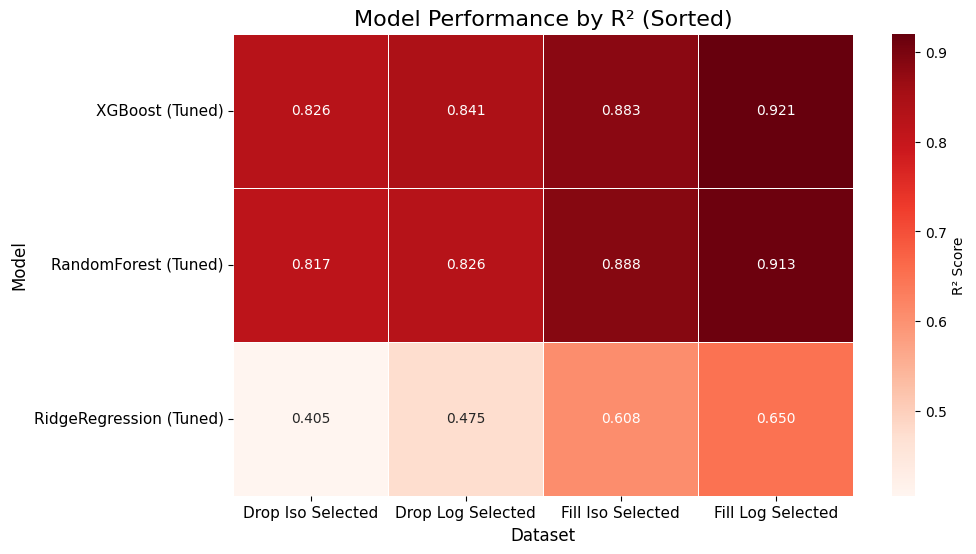

In [27]:
# Convert results_tuned to a DataFrame
results_tuned_df = pd.DataFrame(results_tuned)

# Create a pivot table
heatmap_data = results_tuned_df.pivot(index="Model", columns="Dataset", values="R²")

heatmap_data["Avg R²"] = heatmap_data.mean(axis=1)
heatmap_data.sort_values("Avg R²", ascending=False, inplace=True)
heatmap_data.drop(columns="Avg R²", inplace=True)

# Red theme color map
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="Reds",          # red theme
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "R² Score"}
)

plt.title("Model Performance by R² (Sorted)", fontsize=16)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


In [28]:
# Convert to DataFrame
df_no_tune = pd.DataFrame(results_no_hyper_tune)
df_tuned = pd.DataFrame(results_tuned)

# Clean up model/dataset names
df_tuned["Model"] = df_tuned["Model"].str.replace(r" \(Tuned\)", "", regex=True)
df_tuned["Dataset"] = df_tuned["Dataset"].str.replace(r" Selected", "", regex=True)

# Merge for comparison
comparison = pd.merge(
    df_no_tune,
    df_tuned,
    on=["Dataset", "Model"],
    suffixes=("_NoTune", "_Tuned")
)

# Compute differences
comparison["Δ R²"] = comparison["R²_Tuned"] - comparison["R²_NoTune"]
comparison["Δ RMSE"] = comparison["RMSE_NoTune"] - comparison["RMSE_Tuned"]
comparison["Δ MAE"] = comparison["MAE_NoTune"] - comparison["MAE_Tuned"]
comparison["Δ PMAE"] = comparison["PMAE (%)_NoTune"] - comparison["PMAE (%)_Tuned"]

# Round for display
comparison = comparison.round(3)

# Sort by R² improvement
comparison.sort_values(by="Δ R²", ascending=False, inplace=True)
comparison.reset_index(drop=True, inplace=True)

# Style the comparison DataFrame
styled_comparison = comparison.style.format({
    "R²_NoTune": "{:.4f}",
    "RMSE_NoTune": "{:,.2f}",
    "MAE_NoTune": "{:,.2f}",
    "PMAE (%)_NoTune": "{:.2f}",
    "R²_Tuned": "{:.4f}",
    "RMSE_Tuned": "{:,.2f}",
    "MAE_Tuned": "{:,.2f}",
    "PMAE (%)_Tuned": "{:.2f}",
    "Δ R²": "{:.4f}",
    "Δ RMSE": "{:,.2f}",
    "Δ MAE": "{:,.2f}",
    "Δ PMAE": "{:.2f}"
}).background_gradient(subset=["R²_Tuned", "Δ R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE_Tuned", "MAE_Tuned", "PMAE (%)_Tuned", "Δ RMSE", "Δ MAE", "Δ PMAE"], cmap="Oranges") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_comparison

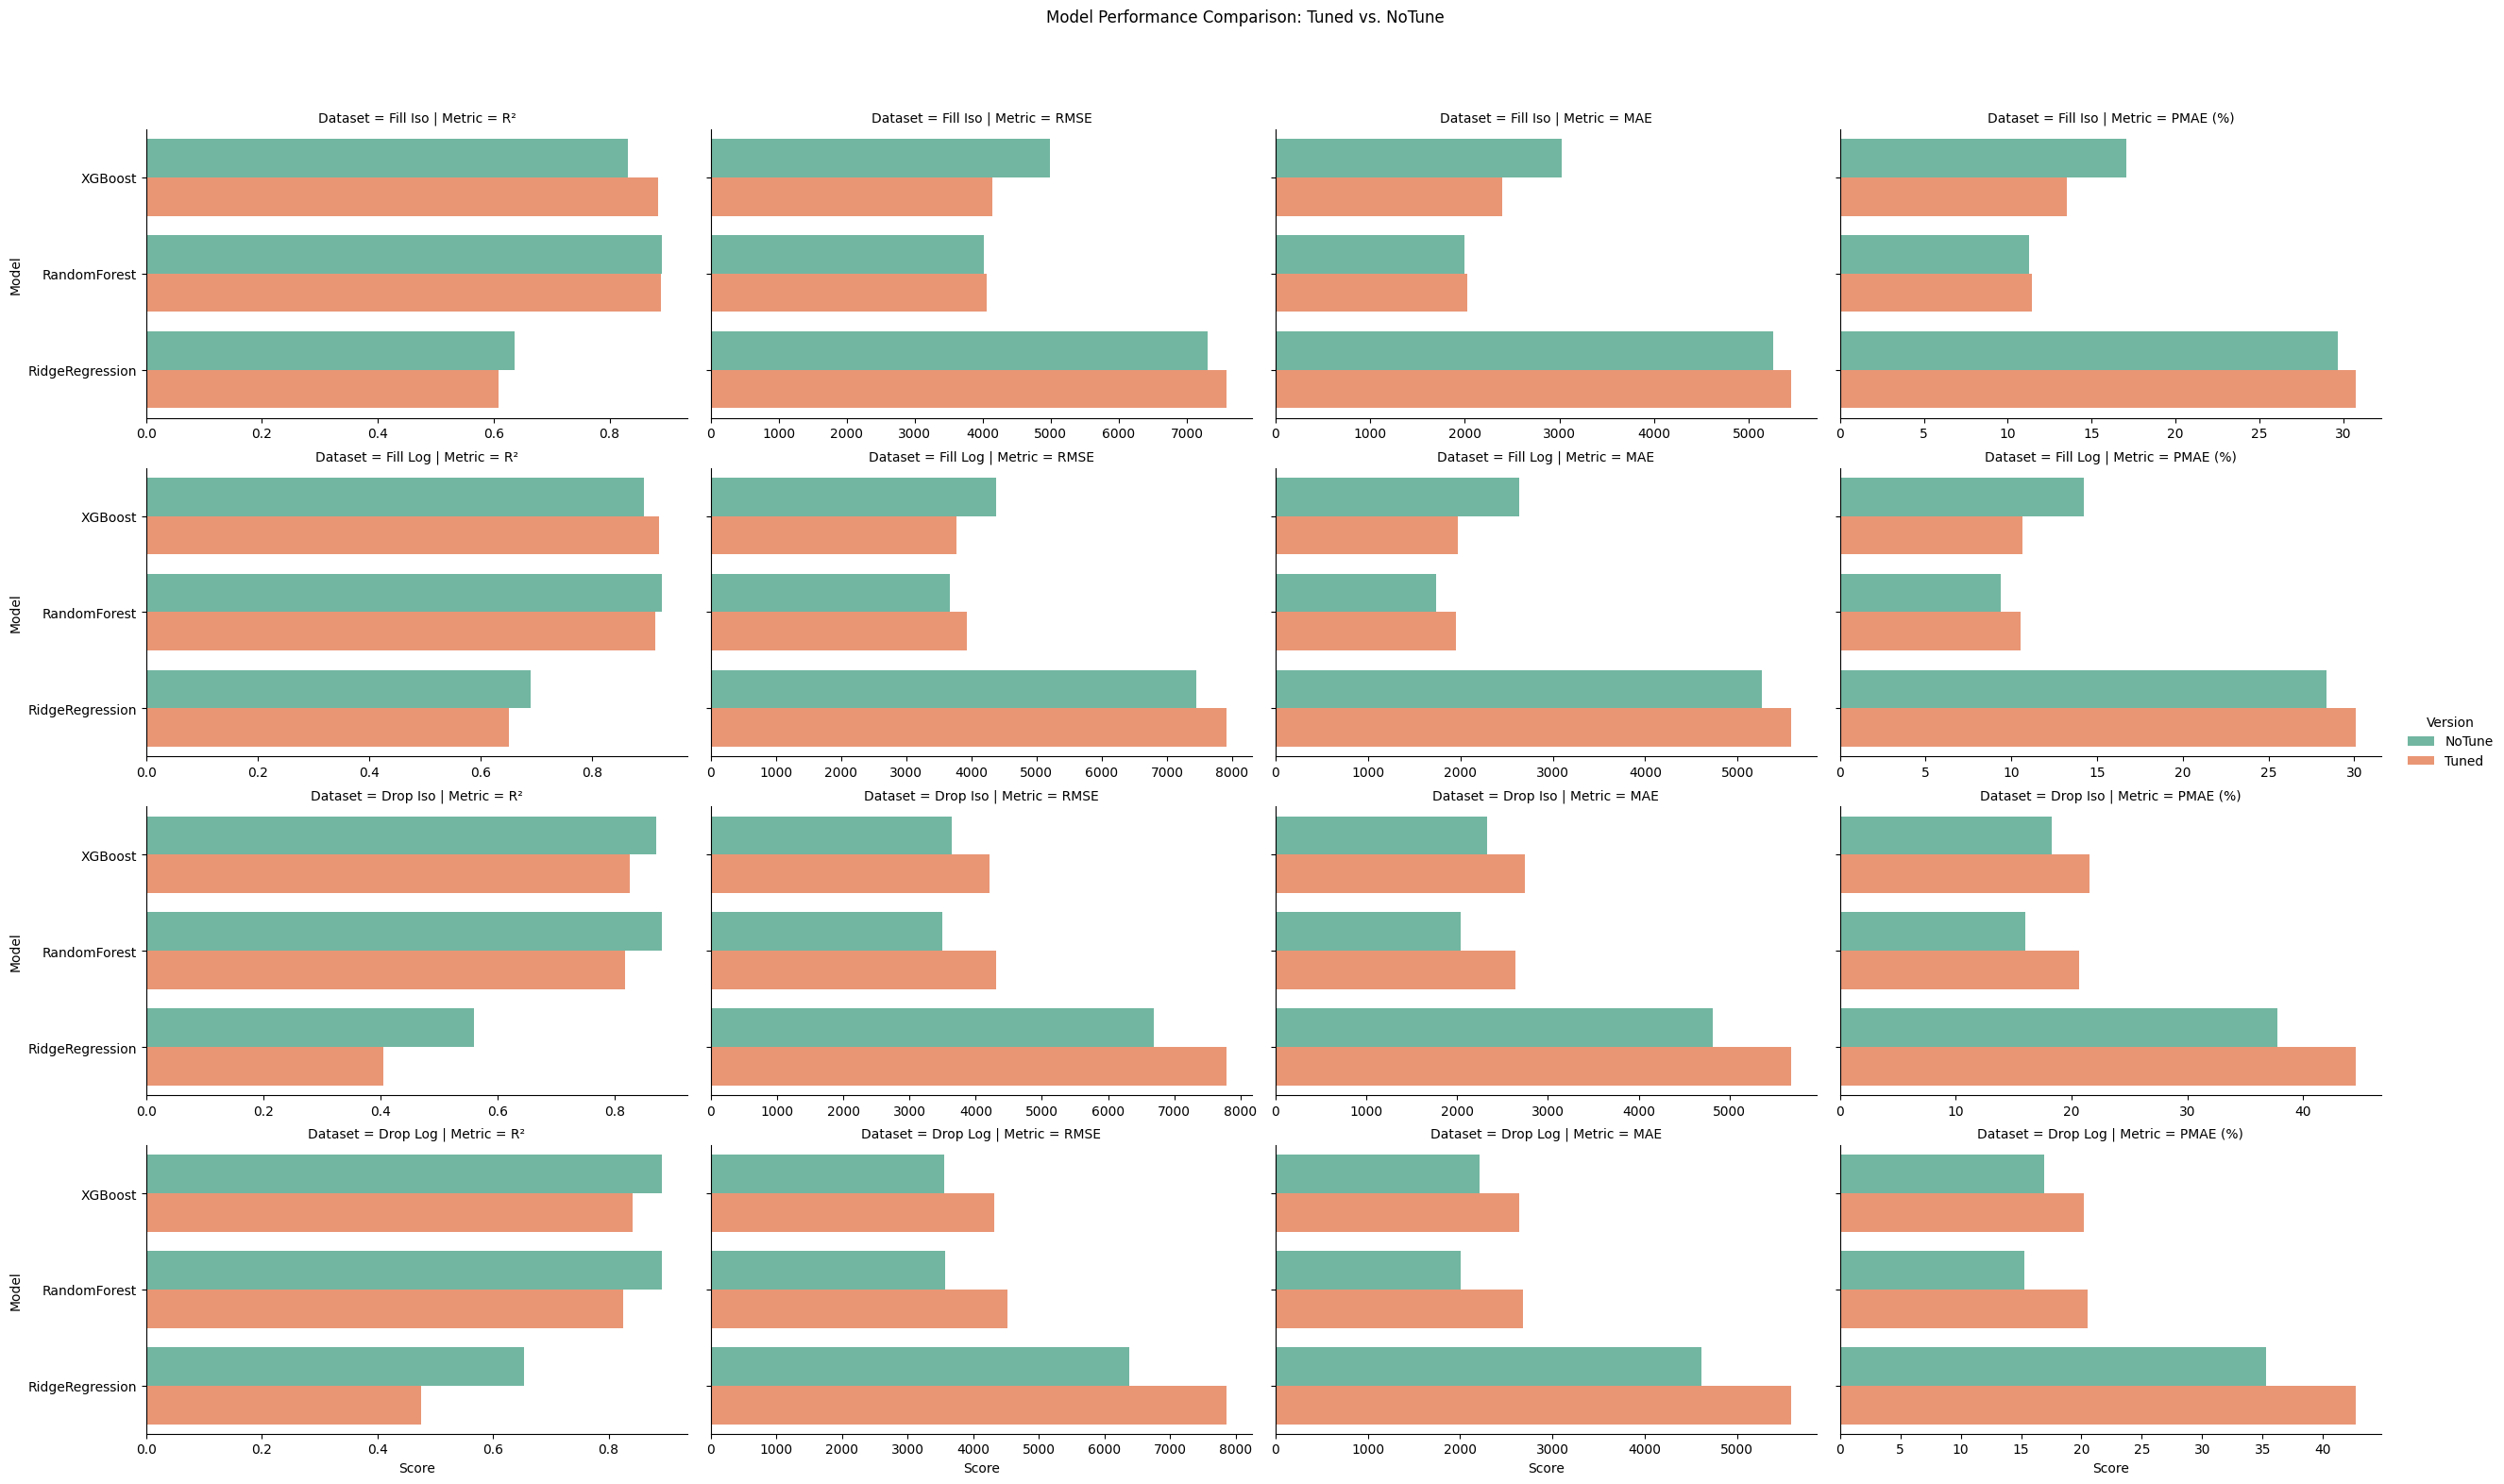

In [29]:
metrics = ["R²", "RMSE", "MAE", "PMAE (%)"]
melted = pd.melt(
    comparison,
    id_vars=["Dataset", "Model"],
    value_vars=[f"{m}_{sfx}" for m in metrics for sfx in ["NoTune", "Tuned"]],
    var_name="Metric_Version",
    value_name="Score"
)

# Split 'Metric_Version' into two columns: Metric and Version
melted[["Metric", "Version"]] = melted["Metric_Version"].str.extract(r"(.*)_((?:NoTune)|(?:Tuned))")
melted.drop(columns=["Metric_Version"], inplace=True)

# Plot
g = sns.catplot(
    data=melted,
    kind="bar",
    x="Score",
    y="Model",
    hue="Version",
    col="Metric",
    row="Dataset",
    palette="Set2",
    sharex=False,
    height=4,
    aspect=1.6
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Model Performance Comparison: Tuned vs. NoTune")
plt.show()